# Load Packages and init path

## load the packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory

## set the work path

In [7]:
root_path='../'
scenario_path='data/cat_7_binary'

souce_path=root_path+'data/raw_data'
target_path=root_path+scenario_path
print(f'souce_path:{souce_path}')
print(f'target_path:{target_path}')

souce_path:../data/raw_data
target_path:../data/cat_7_binary


# Load Raw Data

In [6]:
!pwd

/Users/haitao/Documents/Github/Kaggle/skin_detection_ISIC_2019/notebooks


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


the shape of the processed data setis (25331, 10)


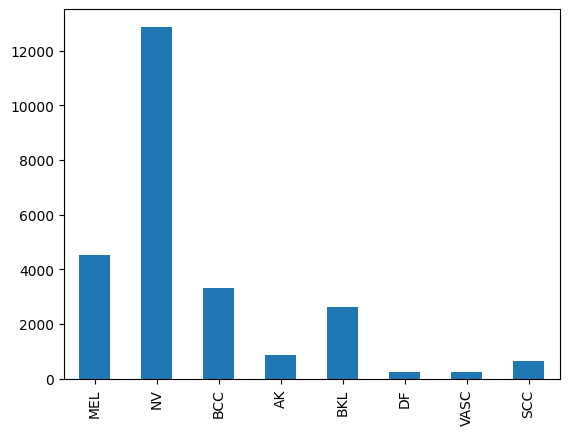

In [8]:
data = pd.read_csv(f'{souce_path}/ISIC_2019_Training_GroundTruth.csv')
display(data.head())
print(f'the shape of the processed data setis {data.shape}')
data.sum()[1:9].plot.bar();

In [9]:
CATEGORIES = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

categories=CATEGORIES
data_by_cat={}
for cat in categories:
    data_by_cat[cat]=data[data[cat]>0]; 
    print(f'shape of data_by_cat[{cat}]: {data_by_cat[cat].shape}')

shape of data_by_cat[MEL]: (4522, 10)
shape of data_by_cat[NV]: (12875, 10)
shape of data_by_cat[BCC]: (3323, 10)
shape of data_by_cat[AK]: (867, 10)
shape of data_by_cat[BKL]: (2624, 10)
shape of data_by_cat[DF]: (239, 10)
shape of data_by_cat[VASC]: (253, 10)
shape of data_by_cat[SCC]: (628, 10)


# Helper functions

## Helper functions for image preprocessing

In [46]:
from PIL import Image

def square_image(image: Image)->Image:
    """
    crop image to sqare
    """
    width, height = image.size
    # Determine the size of the square crop
    size = min(width, height)

    # Calculate the crop coordinates
    left = (width - size) // 2
    top = (height - size) // 2
    right = left + size
    bottom = top + size

    # Perform the crop
    squared_image = image.crop((left, top, right, bottom))

    return squared_image


def detect_black_coners(image: Image)->int:
    """
    return the radius of the circle if detected black coner, otherwise, return -1
    This function needs to be improved for better accuracy if needed
    Args:
        image (Image): The image object which may have black corners.

    Returns:
        int: the radius of circle where is the the black corners from
    """
    width, height=image.size
    scope=min(width, height)//4 # the minimum radius to search for
    step=3  # for better searching performance
    margin=0.98

    if width!=height:
        image = square_image(image)

    b_w_image = image.convert('L')
    for i in range(1, scope, step):
        left=i;right=width-i; top=i; bottom=height-i
        color1=b_w_image.getpixel((top, left))
        color2=b_w_image.getpixel((top, right))
        color3=b_w_image.getpixel((bottom, left))
        color4=b_w_image.getpixel((bottom, right))

        if color1+color2+color3+color4>300:
            break
    if i>1:
        radius = int((width//2-i)*np.sqrt(2)*margin)
        # print(f'black corner detected, the radius is {radius}')
        return radius

    # print(f'No black corner detected')
    return -1

def remove_black_corners(image, radius) -> Image:
    """
    This function remove the black corners of an image

    Args:
        image: The image object to which has black corners.
        radius: the readius of the black corners

    Returns:
        image: image object which the black corners have been removed.
    """
    width, height=image.size

    new_width=int(radius*np.sqrt(2))
    x = (width-new_width)//2
    crop_area=(x, x, width-x, width-x)
    image = image.crop(crop_area)

    return image

def process_and_save_image(source_file, target_file, argument=False):
    # Load the image
    image = Image.open(source_file)
    # Square_Crop
    image = square_image(image)

    # Detect and remove corner edges
    radius = detect_black_coners(image)
    if radius> 0:
        image=remove_black_corners(image, radius=radius)
    # resize image
    image = image.resize((400,400),resample=Image.BILINEAR)
    
    # export image file
    image.save(f'{target_file}.jpg')
    print(f'file {target_file} saved...')
    
    if argument:
        for i in range(3):
            image = image.rotate(90)
            image.save(f'{target_file}_{i}.jpg')
            print(f'file {target_file}_{i}.jpg saved...')
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
        print(f'file {target_file}_{i} saved...')
        

## Helper functions for files

In [29]:
def create_folder(folder_path):
    import os
    import shutil

    # Check if the folder already exists
    if os.path.exists(folder_path):
        # Delete the existing folder
        shutil.rmtree(folder_path)

    # Create the folder
    os.makedirs(folder_path)

## Helper function(s) for visualization

In [166]:
def plot_history(history, title='', axs=None, exp_name=""):
    f,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20, 4))
    
    ax1.plot(history.history['loss'], label='train loss')
    ax1.plot(history.history['val_loss'], label='val loss')
    ax1.set_title('Loss')
    ax1.set_ylim(0.0, 100.0)
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy')
    ax2.plot(history.history['val_accuracy'], label='val accuracy')
    ax2.set_title('Accuracy')
    ax2.axhline(y=0.9, color='green', linestyle='--')
    ax2.set_ylim(0.5, 1.0)
    ax2.legend()
    
    ax3.plot(history.history['recall'], label='train')
    ax3.plot(history.history['val_recall'], label='val')
    ax3.set_title('recall')
    ax3.axhline(y=0.9, color='green', linestyle='--')
    ax3.set_ylim(0.5, 1.0)
    ax3.legend()

    ax4.plot(history.history['f1_metric'], label='train f1_metric')
    ax4.plot(history.history['val_f1_metric'], label='val f1_metric')
    ax4.set_title('f1_metric')
    ax4.axhline(y=0.9, color='green', linestyle='--')
    ax4.set_ylim(0.5, 1.0)
    ax4.legend()

    return (ax1, ax2, ax3, ax4)

# Data Preprocessing 

In [47]:
# ##########################################################################
# # Please call this function only once you need re-prepare all the data
# ##########################################################################

# from sklearn.model_selection import train_test_split

# def data_prep(categories=CATEGORIES, binary=True, n_max=1000, test_size=0.2, argument_if_needed=False):
#     # Create Folders
#     create_folder(target_path)
#     if binary:
#         create_folder(f'{target_path}/train')
#         create_folder(f'{target_path}/val')
#         create_folder(f'{target_path}/test')
#     else:
#         for cat in categories:
#             create_folder(f'{target_path}/train/{cat}')
#             create_folder(f'{target_path}/val/{cat}')
#             create_folder(f'{target_path}/test/{cat}')
    
#     for cat in categories:
#         data_all=data_by_cat[cat]
#         argument_needed= data_by_cat[cat].shape[0]<n_max//4 and argument_if_needed
#         if data_by_cat[cat].shape[0]>n_max:
#             data_all=data_by_cat[cat].sample(n_max, random_state=42)

#         data_train, data_test = train_test_split(data_all, test_size=test_size)
#         data_train, data_val = train_test_split(data_train, test_size=test_size)
        
#         for index, row in data_train.iterrows():
#             source_file = f"{souce_path}/{cat}/{row['image']}.jpg"
#             if binary:
#                 target_file = f"{target_path}/train/{row['image']}"
#             else:
#                 target_file = f"{target_path}/train/{cat}/{row['image']}"
#             process_and_save_image(source_file, target_file, argument_needed)
        
#         print('======================================================')
        
#         for index, row in data_val.iterrows():
#             source_file = f"{souce_path}/{cat}/{row['image']}.jpg"
#             if binary:
#                 target_file = f"{target_path}/val/{row['image']}"
#             else:
#                 target_file = f"{target_path}/val/{cat}/{row['image']}"
#             process_and_save_image(source_file, target_file, argument_needed)
        
#         print('======================================================')
        
#         for index, row in data_test.iterrows():
#             source_file = f"{souce_path}/{cat}/{row['image']}.jpg"
#             if binary:
#                 target_file = f"{target_path}/test/{row['image']}"
#             else:
#                 target_file = f"{target_path}/test/{cat}/{row['image']}"
#             process_and_save_image(source_file, target_file, False)
#     return

# data_prep(['AK', 'SCC'], 
#            binary=False, 
#            n_max=5000, 
#            test_size=0.2, 
#            argument_if_needed=True)

file ../cat_8/train/AK/ISIC_0053738 saved...
file ../cat_8/train/AK/ISIC_0053738_0.jpg saved...
file ../cat_8/train/AK/ISIC_0053738_1.jpg saved...
file ../cat_8/train/AK/ISIC_0053738_2.jpg saved...
file ../cat_8/train/AK/ISIC_0053738_2 saved...
file ../cat_8/train/AK/ISIC_0070737 saved...
file ../cat_8/train/AK/ISIC_0070737_0.jpg saved...
file ../cat_8/train/AK/ISIC_0070737_1.jpg saved...
file ../cat_8/train/AK/ISIC_0070737_2.jpg saved...
file ../cat_8/train/AK/ISIC_0070737_2 saved...
file ../cat_8/train/AK/ISIC_0026702 saved...
file ../cat_8/train/AK/ISIC_0026702_0.jpg saved...
file ../cat_8/train/AK/ISIC_0026702_1.jpg saved...
file ../cat_8/train/AK/ISIC_0026702_2.jpg saved...
file ../cat_8/train/AK/ISIC_0026702_2 saved...
file ../cat_8/train/AK/ISIC_0053664 saved...
file ../cat_8/train/AK/ISIC_0053664_0.jpg saved...
file ../cat_8/train/AK/ISIC_0053664_1.jpg saved...
file ../cat_8/train/AK/ISIC_0053664_2.jpg saved...
file ../cat_8/train/AK/ISIC_0053664_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0061767 saved...
file ../cat_8/train/AK/ISIC_0061767_0.jpg saved...
file ../cat_8/train/AK/ISIC_0061767_1.jpg saved...
file ../cat_8/train/AK/ISIC_0061767_2.jpg saved...
file ../cat_8/train/AK/ISIC_0061767_2 saved...
file ../cat_8/train/AK/ISIC_0068175 saved...
file ../cat_8/train/AK/ISIC_0068175_0.jpg saved...
file ../cat_8/train/AK/ISIC_0068175_1.jpg saved...
file ../cat_8/train/AK/ISIC_0068175_2.jpg saved...
file ../cat_8/train/AK/ISIC_0068175_2 saved...
file ../cat_8/train/AK/ISIC_0058153 saved...
file ../cat_8/train/AK/ISIC_0058153_0.jpg saved...
file ../cat_8/train/AK/ISIC_0058153_1.jpg saved...
file ../cat_8/train/AK/ISIC_0058153_2.jpg saved...
file ../cat_8/train/AK/ISIC_0058153_2 saved...
file ../cat_8/train/AK/ISIC_0026457 saved...
file ../cat_8/train/AK/ISIC_0026457_0.jpg saved...
file ../cat_8/train/AK/ISIC_0026457_1.jpg saved...
file ../cat_8/train/AK/ISIC_0026457_2.jpg saved...
file ../cat_8/train/AK/ISIC_0026457_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0068370 saved...
file ../cat_8/train/AK/ISIC_0068370_0.jpg saved...
file ../cat_8/train/AK/ISIC_0068370_1.jpg saved...
file ../cat_8/train/AK/ISIC_0068370_2.jpg saved...
file ../cat_8/train/AK/ISIC_0068370_2 saved...
file ../cat_8/train/AK/ISIC_0060230 saved...
file ../cat_8/train/AK/ISIC_0060230_0.jpg saved...
file ../cat_8/train/AK/ISIC_0060230_1.jpg saved...
file ../cat_8/train/AK/ISIC_0060230_2.jpg saved...
file ../cat_8/train/AK/ISIC_0060230_2 saved...
file ../cat_8/train/AK/ISIC_0063927 saved...
file ../cat_8/train/AK/ISIC_0063927_0.jpg saved...
file ../cat_8/train/AK/ISIC_0063927_1.jpg saved...
file ../cat_8/train/AK/ISIC_0063927_2.jpg saved...
file ../cat_8/train/AK/ISIC_0063927_2 saved...
file ../cat_8/train/AK/ISIC_0071256 saved...
file ../cat_8/train/AK/ISIC_0071256_0.jpg saved...
file ../cat_8/train/AK/ISIC_0071256_1.jpg saved...
file ../cat_8/train/AK/ISIC_0071256_2.jpg saved...
file ../cat_8/train/AK/ISIC_0071256_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0072861 saved...
file ../cat_8/train/AK/ISIC_0072861_0.jpg saved...
file ../cat_8/train/AK/ISIC_0072861_1.jpg saved...
file ../cat_8/train/AK/ISIC_0072861_2.jpg saved...
file ../cat_8/train/AK/ISIC_0072861_2 saved...
file ../cat_8/train/AK/ISIC_0062608 saved...
file ../cat_8/train/AK/ISIC_0062608_0.jpg saved...
file ../cat_8/train/AK/ISIC_0062608_1.jpg saved...
file ../cat_8/train/AK/ISIC_0062608_2.jpg saved...
file ../cat_8/train/AK/ISIC_0062608_2 saved...
file ../cat_8/train/AK/ISIC_0027334 saved...
file ../cat_8/train/AK/ISIC_0027334_0.jpg saved...
file ../cat_8/train/AK/ISIC_0027334_1.jpg saved...
file ../cat_8/train/AK/ISIC_0027334_2.jpg saved...
file ../cat_8/train/AK/ISIC_0027334_2 saved...
file ../cat_8/train/AK/ISIC_0071500 saved...
file ../cat_8/train/AK/ISIC_0071500_0.jpg saved...
file ../cat_8/train/AK/ISIC_0071500_1.jpg saved...
file ../cat_8/train/AK/ISIC_0071500_2.jpg saved...
file ../cat_8/train/AK/ISIC_0071500_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0054687 saved...
file ../cat_8/train/AK/ISIC_0054687_0.jpg saved...
file ../cat_8/train/AK/ISIC_0054687_1.jpg saved...
file ../cat_8/train/AK/ISIC_0054687_2.jpg saved...
file ../cat_8/train/AK/ISIC_0054687_2 saved...
file ../cat_8/train/AK/ISIC_0065724 saved...
file ../cat_8/train/AK/ISIC_0065724_0.jpg saved...
file ../cat_8/train/AK/ISIC_0065724_1.jpg saved...
file ../cat_8/train/AK/ISIC_0065724_2.jpg saved...
file ../cat_8/train/AK/ISIC_0065724_2 saved...
file ../cat_8/train/AK/ISIC_0067490 saved...
file ../cat_8/train/AK/ISIC_0067490_0.jpg saved...
file ../cat_8/train/AK/ISIC_0067490_1.jpg saved...
file ../cat_8/train/AK/ISIC_0067490_2.jpg saved...
file ../cat_8/train/AK/ISIC_0067490_2 saved...
file ../cat_8/train/AK/ISIC_0067887 saved...
file ../cat_8/train/AK/ISIC_0067887_0.jpg saved...
file ../cat_8/train/AK/ISIC_0067887_1.jpg saved...
file ../cat_8/train/AK/ISIC_0067887_2.jpg saved...
file ../cat_8/train/AK/ISIC_0067887_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0067468_2.jpg saved...
file ../cat_8/train/AK/ISIC_0067468_2 saved...
file ../cat_8/train/AK/ISIC_0054533 saved...
file ../cat_8/train/AK/ISIC_0054533_0.jpg saved...
file ../cat_8/train/AK/ISIC_0054533_1.jpg saved...
file ../cat_8/train/AK/ISIC_0054533_2.jpg saved...
file ../cat_8/train/AK/ISIC_0054533_2 saved...
file ../cat_8/train/AK/ISIC_0069772 saved...
file ../cat_8/train/AK/ISIC_0069772_0.jpg saved...
file ../cat_8/train/AK/ISIC_0069772_1.jpg saved...
file ../cat_8/train/AK/ISIC_0069772_2.jpg saved...
file ../cat_8/train/AK/ISIC_0069772_2 saved...
file ../cat_8/train/AK/ISIC_0024771 saved...
file ../cat_8/train/AK/ISIC_0024771_0.jpg saved...
file ../cat_8/train/AK/ISIC_0024771_1.jpg saved...
file ../cat_8/train/AK/ISIC_0024771_2.jpg saved...
file ../cat_8/train/AK/ISIC_0024771_2 saved...
file ../cat_8/train/AK/ISIC_0031335 saved...
file ../cat_8/train/AK/ISIC_0031335_0.jpg saved...
file ../cat_8/train/AK/ISIC_0031335_1.jpg saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0062345 saved...
file ../cat_8/train/AK/ISIC_0062345_0.jpg saved...
file ../cat_8/train/AK/ISIC_0062345_1.jpg saved...
file ../cat_8/train/AK/ISIC_0062345_2.jpg saved...
file ../cat_8/train/AK/ISIC_0062345_2 saved...
file ../cat_8/train/AK/ISIC_0073130 saved...
file ../cat_8/train/AK/ISIC_0073130_0.jpg saved...
file ../cat_8/train/AK/ISIC_0073130_1.jpg saved...
file ../cat_8/train/AK/ISIC_0073130_2.jpg saved...
file ../cat_8/train/AK/ISIC_0073130_2 saved...
file ../cat_8/train/AK/ISIC_0068232 saved...
file ../cat_8/train/AK/ISIC_0068232_0.jpg saved...
file ../cat_8/train/AK/ISIC_0068232_1.jpg saved...
file ../cat_8/train/AK/ISIC_0068232_2.jpg saved...
file ../cat_8/train/AK/ISIC_0068232_2 saved...
file ../cat_8/train/AK/ISIC_0033705 saved...
file ../cat_8/train/AK/ISIC_0033705_0.jpg saved...
file ../cat_8/train/AK/ISIC_0033705_1.jpg saved...
file ../cat_8/train/AK/ISIC_0033705_2.jpg saved...
file ../cat_8/train/AK/ISIC_0033705_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0060509 saved...
file ../cat_8/train/AK/ISIC_0060509_0.jpg saved...
file ../cat_8/train/AK/ISIC_0060509_1.jpg saved...
file ../cat_8/train/AK/ISIC_0060509_2.jpg saved...
file ../cat_8/train/AK/ISIC_0060509_2 saved...
file ../cat_8/train/AK/ISIC_0069352 saved...
file ../cat_8/train/AK/ISIC_0069352_0.jpg saved...
file ../cat_8/train/AK/ISIC_0069352_1.jpg saved...
file ../cat_8/train/AK/ISIC_0069352_2.jpg saved...
file ../cat_8/train/AK/ISIC_0069352_2 saved...
file ../cat_8/train/AK/ISIC_0063122 saved...
file ../cat_8/train/AK/ISIC_0063122_0.jpg saved...
file ../cat_8/train/AK/ISIC_0063122_1.jpg saved...
file ../cat_8/train/AK/ISIC_0063122_2.jpg saved...
file ../cat_8/train/AK/ISIC_0063122_2 saved...
file ../cat_8/train/AK/ISIC_0060122 saved...
file ../cat_8/train/AK/ISIC_0060122_0.jpg saved...
file ../cat_8/train/AK/ISIC_0060122_1.jpg saved...
file ../cat_8/train/AK/ISIC_0060122_2.jpg saved...
file ../cat_8/train/AK/ISIC_0060122_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0056052 saved...
file ../cat_8/train/AK/ISIC_0056052_0.jpg saved...
file ../cat_8/train/AK/ISIC_0056052_1.jpg saved...
file ../cat_8/train/AK/ISIC_0056052_2.jpg saved...
file ../cat_8/train/AK/ISIC_0056052_2 saved...
file ../cat_8/train/AK/ISIC_0069802 saved...
file ../cat_8/train/AK/ISIC_0069802_0.jpg saved...
file ../cat_8/train/AK/ISIC_0069802_1.jpg saved...
file ../cat_8/train/AK/ISIC_0069802_2.jpg saved...
file ../cat_8/train/AK/ISIC_0069802_2 saved...
file ../cat_8/train/AK/ISIC_0033866 saved...
file ../cat_8/train/AK/ISIC_0033866_0.jpg saved...
file ../cat_8/train/AK/ISIC_0033866_1.jpg saved...
file ../cat_8/train/AK/ISIC_0033866_2.jpg saved...
file ../cat_8/train/AK/ISIC_0033866_2 saved...
file ../cat_8/train/AK/ISIC_0054181 saved...
file ../cat_8/train/AK/ISIC_0054181_0.jpg saved...
file ../cat_8/train/AK/ISIC_0054181_1.jpg saved...
file ../cat_8/train/AK/ISIC_0054181_2.jpg saved...
file ../cat_8/train/AK/ISIC_0054181_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0072038 saved...
file ../cat_8/train/AK/ISIC_0072038_0.jpg saved...
file ../cat_8/train/AK/ISIC_0072038_1.jpg saved...
file ../cat_8/train/AK/ISIC_0072038_2.jpg saved...
file ../cat_8/train/AK/ISIC_0072038_2 saved...
file ../cat_8/train/AK/ISIC_0061730 saved...
file ../cat_8/train/AK/ISIC_0061730_0.jpg saved...
file ../cat_8/train/AK/ISIC_0061730_1.jpg saved...
file ../cat_8/train/AK/ISIC_0061730_2.jpg saved...
file ../cat_8/train/AK/ISIC_0061730_2 saved...
file ../cat_8/train/AK/ISIC_0065811 saved...
file ../cat_8/train/AK/ISIC_0065811_0.jpg saved...
file ../cat_8/train/AK/ISIC_0065811_1.jpg saved...
file ../cat_8/train/AK/ISIC_0065811_2.jpg saved...
file ../cat_8/train/AK/ISIC_0065811_2 saved...
file ../cat_8/train/AK/ISIC_0069719 saved...
file ../cat_8/train/AK/ISIC_0069719_0.jpg saved...
file ../cat_8/train/AK/ISIC_0069719_1.jpg saved...
file ../cat_8/train/AK/ISIC_0069719_2.jpg saved...
file ../cat_8/train/AK/ISIC_0069719_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0069931 saved...
file ../cat_8/train/AK/ISIC_0069931_0.jpg saved...
file ../cat_8/train/AK/ISIC_0069931_1.jpg saved...
file ../cat_8/train/AK/ISIC_0069931_2.jpg saved...
file ../cat_8/train/AK/ISIC_0069931_2 saved...
file ../cat_8/train/AK/ISIC_0071953 saved...
file ../cat_8/train/AK/ISIC_0071953_0.jpg saved...
file ../cat_8/train/AK/ISIC_0071953_1.jpg saved...
file ../cat_8/train/AK/ISIC_0071953_2.jpg saved...
file ../cat_8/train/AK/ISIC_0071953_2 saved...
file ../cat_8/train/AK/ISIC_0030730 saved...
file ../cat_8/train/AK/ISIC_0030730_0.jpg saved...
file ../cat_8/train/AK/ISIC_0030730_1.jpg saved...
file ../cat_8/train/AK/ISIC_0030730_2.jpg saved...
file ../cat_8/train/AK/ISIC_0030730_2 saved...
file ../cat_8/train/AK/ISIC_0058623 saved...
file ../cat_8/train/AK/ISIC_0058623_0.jpg saved...
file ../cat_8/train/AK/ISIC_0058623_1.jpg saved...
file ../cat_8/train/AK/ISIC_0058623_2.jpg saved...
file ../cat_8/train/AK/ISIC_0058623_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0072754 saved...
file ../cat_8/train/AK/ISIC_0072754_0.jpg saved...
file ../cat_8/train/AK/ISIC_0072754_1.jpg saved...
file ../cat_8/train/AK/ISIC_0072754_2.jpg saved...
file ../cat_8/train/AK/ISIC_0072754_2 saved...
file ../cat_8/train/AK/ISIC_0028393 saved...
file ../cat_8/train/AK/ISIC_0028393_0.jpg saved...
file ../cat_8/train/AK/ISIC_0028393_1.jpg saved...
file ../cat_8/train/AK/ISIC_0028393_2.jpg saved...
file ../cat_8/train/AK/ISIC_0028393_2 saved...
file ../cat_8/train/AK/ISIC_0071108 saved...
file ../cat_8/train/AK/ISIC_0071108_0.jpg saved...
file ../cat_8/train/AK/ISIC_0071108_1.jpg saved...
file ../cat_8/train/AK/ISIC_0071108_2.jpg saved...
file ../cat_8/train/AK/ISIC_0071108_2 saved...
file ../cat_8/train/AK/ISIC_0066507 saved...
file ../cat_8/train/AK/ISIC_0066507_0.jpg saved...
file ../cat_8/train/AK/ISIC_0066507_1.jpg saved...
file ../cat_8/train/AK/ISIC_0066507_2.jpg saved...
file ../cat_8/train/AK/ISIC_0066507_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0026625 saved...
file ../cat_8/train/AK/ISIC_0026625_0.jpg saved...
file ../cat_8/train/AK/ISIC_0026625_1.jpg saved...
file ../cat_8/train/AK/ISIC_0026625_2.jpg saved...
file ../cat_8/train/AK/ISIC_0026625_2 saved...
file ../cat_8/train/AK/ISIC_0058762 saved...
file ../cat_8/train/AK/ISIC_0058762_0.jpg saved...
file ../cat_8/train/AK/ISIC_0058762_1.jpg saved...
file ../cat_8/train/AK/ISIC_0058762_2.jpg saved...
file ../cat_8/train/AK/ISIC_0058762_2 saved...
file ../cat_8/train/AK/ISIC_0069630 saved...
file ../cat_8/train/AK/ISIC_0069630_0.jpg saved...
file ../cat_8/train/AK/ISIC_0069630_1.jpg saved...
file ../cat_8/train/AK/ISIC_0069630_2.jpg saved...
file ../cat_8/train/AK/ISIC_0069630_2 saved...
file ../cat_8/train/AK/ISIC_0061376 saved...
file ../cat_8/train/AK/ISIC_0061376_0.jpg saved...
file ../cat_8/train/AK/ISIC_0061376_1.jpg saved...
file ../cat_8/train/AK/ISIC_0061376_2.jpg saved...
file ../cat_8/train/AK/ISIC_0061376_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0055331 saved...
file ../cat_8/train/AK/ISIC_0055331_0.jpg saved...
file ../cat_8/train/AK/ISIC_0055331_1.jpg saved...
file ../cat_8/train/AK/ISIC_0055331_2.jpg saved...
file ../cat_8/train/AK/ISIC_0055331_2 saved...
file ../cat_8/train/AK/ISIC_0065495 saved...
file ../cat_8/train/AK/ISIC_0065495_0.jpg saved...
file ../cat_8/train/AK/ISIC_0065495_1.jpg saved...
file ../cat_8/train/AK/ISIC_0065495_2.jpg saved...
file ../cat_8/train/AK/ISIC_0065495_2 saved...
file ../cat_8/train/AK/ISIC_0058967 saved...
file ../cat_8/train/AK/ISIC_0058967_0.jpg saved...
file ../cat_8/train/AK/ISIC_0058967_1.jpg saved...
file ../cat_8/train/AK/ISIC_0058967_2.jpg saved...
file ../cat_8/train/AK/ISIC_0058967_2 saved...
file ../cat_8/train/AK/ISIC_0063187 saved...
file ../cat_8/train/AK/ISIC_0063187_0.jpg saved...
file ../cat_8/train/AK/ISIC_0063187_1.jpg saved...
file ../cat_8/train/AK/ISIC_0063187_2.jpg saved...
file ../cat_8/train/AK/ISIC_0063187_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0062741 saved...
file ../cat_8/train/AK/ISIC_0062741_0.jpg saved...
file ../cat_8/train/AK/ISIC_0062741_1.jpg saved...
file ../cat_8/train/AK/ISIC_0062741_2.jpg saved...
file ../cat_8/train/AK/ISIC_0062741_2 saved...
file ../cat_8/train/AK/ISIC_0026040 saved...
file ../cat_8/train/AK/ISIC_0026040_0.jpg saved...
file ../cat_8/train/AK/ISIC_0026040_1.jpg saved...
file ../cat_8/train/AK/ISIC_0026040_2.jpg saved...
file ../cat_8/train/AK/ISIC_0026040_2 saved...
file ../cat_8/train/AK/ISIC_0067759 saved...
file ../cat_8/train/AK/ISIC_0067759_0.jpg saved...
file ../cat_8/train/AK/ISIC_0067759_1.jpg saved...
file ../cat_8/train/AK/ISIC_0067759_2.jpg saved...
file ../cat_8/train/AK/ISIC_0067759_2 saved...
file ../cat_8/train/AK/ISIC_0029840 saved...
file ../cat_8/train/AK/ISIC_0029840_0.jpg saved...
file ../cat_8/train/AK/ISIC_0029840_1.jpg saved...
file ../cat_8/train/AK/ISIC_0029840_2.jpg saved...
file ../cat_8/train/AK/ISIC_0029840_2 saved...
file ../cat_8/train/

file ../cat_8/train/AK/ISIC_0069939 saved...
file ../cat_8/train/AK/ISIC_0069939_0.jpg saved...
file ../cat_8/train/AK/ISIC_0069939_1.jpg saved...
file ../cat_8/train/AK/ISIC_0069939_2.jpg saved...
file ../cat_8/train/AK/ISIC_0069939_2 saved...
file ../cat_8/train/AK/ISIC_0067450 saved...
file ../cat_8/train/AK/ISIC_0067450_0.jpg saved...
file ../cat_8/train/AK/ISIC_0067450_1.jpg saved...
file ../cat_8/train/AK/ISIC_0067450_2.jpg saved...
file ../cat_8/train/AK/ISIC_0067450_2 saved...
file ../cat_8/train/AK/ISIC_0064969 saved...
file ../cat_8/train/AK/ISIC_0064969_0.jpg saved...
file ../cat_8/train/AK/ISIC_0064969_1.jpg saved...
file ../cat_8/train/AK/ISIC_0064969_2.jpg saved...
file ../cat_8/train/AK/ISIC_0064969_2 saved...
file ../cat_8/train/AK/ISIC_0025953 saved...
file ../cat_8/train/AK/ISIC_0025953_0.jpg saved...
file ../cat_8/train/AK/ISIC_0025953_1.jpg saved...
file ../cat_8/train/AK/ISIC_0025953_2.jpg saved...
file ../cat_8/train/AK/ISIC_0025953_2 saved...
file ../cat_8/train/

file ../cat_8/val/AK/ISIC_0072152 saved...
file ../cat_8/val/AK/ISIC_0072152_0.jpg saved...
file ../cat_8/val/AK/ISIC_0072152_1.jpg saved...
file ../cat_8/val/AK/ISIC_0072152_2.jpg saved...
file ../cat_8/val/AK/ISIC_0072152_2 saved...
file ../cat_8/val/AK/ISIC_0056724 saved...
file ../cat_8/val/AK/ISIC_0056724_0.jpg saved...
file ../cat_8/val/AK/ISIC_0056724_1.jpg saved...
file ../cat_8/val/AK/ISIC_0056724_2.jpg saved...
file ../cat_8/val/AK/ISIC_0056724_2 saved...
file ../cat_8/val/AK/ISIC_0056867 saved...
file ../cat_8/val/AK/ISIC_0056867_0.jpg saved...
file ../cat_8/val/AK/ISIC_0056867_1.jpg saved...
file ../cat_8/val/AK/ISIC_0056867_2.jpg saved...
file ../cat_8/val/AK/ISIC_0056867_2 saved...
file ../cat_8/val/AK/ISIC_0056037 saved...
file ../cat_8/val/AK/ISIC_0056037_0.jpg saved...
file ../cat_8/val/AK/ISIC_0056037_1.jpg saved...
file ../cat_8/val/AK/ISIC_0056037_2.jpg saved...
file ../cat_8/val/AK/ISIC_0056037_2 saved...
file ../cat_8/val/AK/ISIC_0055475 saved...
file ../cat_8/val

file ../cat_8/val/AK/ISIC_0065304 saved...
file ../cat_8/val/AK/ISIC_0065304_0.jpg saved...
file ../cat_8/val/AK/ISIC_0065304_1.jpg saved...
file ../cat_8/val/AK/ISIC_0065304_2.jpg saved...
file ../cat_8/val/AK/ISIC_0065304_2 saved...
file ../cat_8/val/AK/ISIC_0026765 saved...
file ../cat_8/val/AK/ISIC_0026765_0.jpg saved...
file ../cat_8/val/AK/ISIC_0026765_1.jpg saved...
file ../cat_8/val/AK/ISIC_0026765_2.jpg saved...
file ../cat_8/val/AK/ISIC_0026765_2 saved...
file ../cat_8/val/AK/ISIC_0054921 saved...
file ../cat_8/val/AK/ISIC_0054921_0.jpg saved...
file ../cat_8/val/AK/ISIC_0054921_1.jpg saved...
file ../cat_8/val/AK/ISIC_0054921_2.jpg saved...
file ../cat_8/val/AK/ISIC_0054921_2 saved...
file ../cat_8/val/AK/ISIC_0062814 saved...
file ../cat_8/val/AK/ISIC_0062814_0.jpg saved...
file ../cat_8/val/AK/ISIC_0062814_1.jpg saved...
file ../cat_8/val/AK/ISIC_0062814_2.jpg saved...
file ../cat_8/val/AK/ISIC_0062814_2 saved...
file ../cat_8/val/AK/ISIC_0054137 saved...
file ../cat_8/val

file ../cat_8/val/AK/ISIC_0057987 saved...
file ../cat_8/val/AK/ISIC_0057987_0.jpg saved...
file ../cat_8/val/AK/ISIC_0057987_1.jpg saved...
file ../cat_8/val/AK/ISIC_0057987_2.jpg saved...
file ../cat_8/val/AK/ISIC_0057987_2 saved...
file ../cat_8/val/AK/ISIC_0069483 saved...
file ../cat_8/val/AK/ISIC_0069483_0.jpg saved...
file ../cat_8/val/AK/ISIC_0069483_1.jpg saved...
file ../cat_8/val/AK/ISIC_0069483_2.jpg saved...
file ../cat_8/val/AK/ISIC_0069483_2 saved...
file ../cat_8/val/AK/ISIC_0067432 saved...
file ../cat_8/val/AK/ISIC_0067432_0.jpg saved...
file ../cat_8/val/AK/ISIC_0067432_1.jpg saved...
file ../cat_8/val/AK/ISIC_0067432_2.jpg saved...
file ../cat_8/val/AK/ISIC_0067432_2 saved...
file ../cat_8/val/AK/ISIC_0061285 saved...
file ../cat_8/val/AK/ISIC_0061285_0.jpg saved...
file ../cat_8/val/AK/ISIC_0061285_1.jpg saved...
file ../cat_8/val/AK/ISIC_0061285_2.jpg saved...
file ../cat_8/val/AK/ISIC_0061285_2 saved...
file ../cat_8/val/AK/ISIC_0066220 saved...
file ../cat_8/val

file ../cat_8/val/AK/ISIC_0054531 saved...
file ../cat_8/val/AK/ISIC_0054531_0.jpg saved...
file ../cat_8/val/AK/ISIC_0054531_1.jpg saved...
file ../cat_8/val/AK/ISIC_0054531_2.jpg saved...
file ../cat_8/val/AK/ISIC_0054531_2 saved...
file ../cat_8/val/AK/ISIC_0063712 saved...
file ../cat_8/val/AK/ISIC_0063712_0.jpg saved...
file ../cat_8/val/AK/ISIC_0063712_1.jpg saved...
file ../cat_8/val/AK/ISIC_0063712_2.jpg saved...
file ../cat_8/val/AK/ISIC_0063712_2 saved...
file ../cat_8/val/AK/ISIC_0070116 saved...
file ../cat_8/val/AK/ISIC_0070116_0.jpg saved...
file ../cat_8/val/AK/ISIC_0070116_1.jpg saved...
file ../cat_8/val/AK/ISIC_0070116_2.jpg saved...
file ../cat_8/val/AK/ISIC_0070116_2 saved...
file ../cat_8/val/AK/ISIC_0062940 saved...
file ../cat_8/val/AK/ISIC_0062940_0.jpg saved...
file ../cat_8/val/AK/ISIC_0062940_1.jpg saved...
file ../cat_8/val/AK/ISIC_0062940_2.jpg saved...
file ../cat_8/val/AK/ISIC_0062940_2 saved...
file ../cat_8/val/AK/ISIC_0062238 saved...
file ../cat_8/val

file ../cat_8/test/AK/ISIC_0062742 saved...
file ../cat_8/test/AK/ISIC_0053595 saved...
file ../cat_8/test/AK/ISIC_0063536 saved...
file ../cat_8/test/AK/ISIC_0061687 saved...
file ../cat_8/test/AK/ISIC_0058404 saved...
file ../cat_8/test/AK/ISIC_0066315 saved...
file ../cat_8/test/AK/ISIC_0063175 saved...
file ../cat_8/test/AK/ISIC_0059588 saved...
file ../cat_8/test/AK/ISIC_0057847 saved...
file ../cat_8/test/AK/ISIC_0060636 saved...
file ../cat_8/test/AK/ISIC_0073157 saved...
file ../cat_8/test/AK/ISIC_0063778 saved...
file ../cat_8/test/AK/ISIC_0057679 saved...
file ../cat_8/test/AK/ISIC_0059872 saved...
file ../cat_8/test/AK/ISIC_0058994 saved...
file ../cat_8/test/AK/ISIC_0067945 saved...
file ../cat_8/test/AK/ISIC_0063883 saved...
file ../cat_8/test/AK/ISIC_0058443 saved...
file ../cat_8/test/AK/ISIC_0061814 saved...
file ../cat_8/test/AK/ISIC_0062878 saved...
file ../cat_8/test/AK/ISIC_0069818 saved...
file ../cat_8/test/AK/ISIC_0058239 saved...
file ../cat_8/test/AK/ISIC_00663

file ../cat_8/train/SCC/ISIC_0055700 saved...
file ../cat_8/train/SCC/ISIC_0055700_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0055700_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0055700_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0055700_2 saved...
file ../cat_8/train/SCC/ISIC_0071058 saved...
file ../cat_8/train/SCC/ISIC_0071058_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0071058_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0071058_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0071058_2 saved...
file ../cat_8/train/SCC/ISIC_0026319 saved...
file ../cat_8/train/SCC/ISIC_0026319_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0026319_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0026319_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0026319_2 saved...
file ../cat_8/train/SCC/ISIC_0067544 saved...
file ../cat_8/train/SCC/ISIC_0067544_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0067544_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0067544_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0067544_2 saved...


file ../cat_8/train/SCC/ISIC_0071999 saved...
file ../cat_8/train/SCC/ISIC_0071999_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0071999_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0071999_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0071999_2 saved...
file ../cat_8/train/SCC/ISIC_0059575 saved...
file ../cat_8/train/SCC/ISIC_0059575_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0059575_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0059575_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0059575_2 saved...
file ../cat_8/train/SCC/ISIC_0056927 saved...
file ../cat_8/train/SCC/ISIC_0056927_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0056927_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0056927_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0056927_2 saved...
file ../cat_8/train/SCC/ISIC_0028224 saved...
file ../cat_8/train/SCC/ISIC_0028224_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0028224_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0028224_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0028224_2 saved...


file ../cat_8/train/SCC/ISIC_0057294 saved...
file ../cat_8/train/SCC/ISIC_0057294_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0057294_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0057294_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0057294_2 saved...
file ../cat_8/train/SCC/ISIC_0071322 saved...
file ../cat_8/train/SCC/ISIC_0071322_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0071322_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0071322_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0071322_2 saved...
file ../cat_8/train/SCC/ISIC_0027678 saved...
file ../cat_8/train/SCC/ISIC_0027678_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0027678_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0027678_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0027678_2 saved...
file ../cat_8/train/SCC/ISIC_0068666 saved...
file ../cat_8/train/SCC/ISIC_0068666_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0068666_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0068666_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0068666_2 saved...


file ../cat_8/train/SCC/ISIC_0060580 saved...
file ../cat_8/train/SCC/ISIC_0060580_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0060580_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0060580_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0060580_2 saved...
file ../cat_8/train/SCC/ISIC_0072708 saved...
file ../cat_8/train/SCC/ISIC_0072708_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0072708_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0072708_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0072708_2 saved...
file ../cat_8/train/SCC/ISIC_0031918 saved...
file ../cat_8/train/SCC/ISIC_0031918_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0031918_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0031918_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0031918_2 saved...
file ../cat_8/train/SCC/ISIC_0025577 saved...
file ../cat_8/train/SCC/ISIC_0025577_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0025577_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0025577_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0025577_2 saved...


file ../cat_8/train/SCC/ISIC_0027719 saved...
file ../cat_8/train/SCC/ISIC_0027719_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0027719_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0027719_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0027719_2 saved...
file ../cat_8/train/SCC/ISIC_0056295 saved...
file ../cat_8/train/SCC/ISIC_0056295_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0056295_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0056295_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0056295_2 saved...
file ../cat_8/train/SCC/ISIC_0058120 saved...
file ../cat_8/train/SCC/ISIC_0058120_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0058120_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0058120_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0058120_2 saved...
file ../cat_8/train/SCC/ISIC_0062261 saved...
file ../cat_8/train/SCC/ISIC_0062261_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0062261_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0062261_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0062261_2 saved...


file ../cat_8/train/SCC/ISIC_0070041 saved...
file ../cat_8/train/SCC/ISIC_0070041_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0070041_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0070041_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0070041_2 saved...
file ../cat_8/train/SCC/ISIC_0071817 saved...
file ../cat_8/train/SCC/ISIC_0071817_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0071817_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0071817_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0071817_2 saved...
file ../cat_8/train/SCC/ISIC_0060623 saved...
file ../cat_8/train/SCC/ISIC_0060623_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0060623_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0060623_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0060623_2 saved...
file ../cat_8/train/SCC/ISIC_0059405 saved...
file ../cat_8/train/SCC/ISIC_0059405_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0059405_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0059405_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0059405_2 saved...


file ../cat_8/train/SCC/ISIC_0067075 saved...
file ../cat_8/train/SCC/ISIC_0067075_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0067075_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0067075_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0067075_2 saved...
file ../cat_8/train/SCC/ISIC_0053561 saved...
file ../cat_8/train/SCC/ISIC_0053561_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0053561_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0053561_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0053561_2 saved...
file ../cat_8/train/SCC/ISIC_0063275 saved...
file ../cat_8/train/SCC/ISIC_0063275_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0063275_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0063275_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0063275_2 saved...
file ../cat_8/train/SCC/ISIC_0067212 saved...
file ../cat_8/train/SCC/ISIC_0067212_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0067212_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0067212_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0067212_2 saved...


file ../cat_8/train/SCC/ISIC_0057121 saved...
file ../cat_8/train/SCC/ISIC_0057121_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0057121_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0057121_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0057121_2 saved...
file ../cat_8/train/SCC/ISIC_0072795 saved...
file ../cat_8/train/SCC/ISIC_0072795_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0072795_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0072795_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0072795_2 saved...
file ../cat_8/train/SCC/ISIC_0065816 saved...
file ../cat_8/train/SCC/ISIC_0065816_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0065816_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0065816_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0065816_2 saved...
file ../cat_8/train/SCC/ISIC_0067982 saved...
file ../cat_8/train/SCC/ISIC_0067982_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0067982_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0067982_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0067982_2 saved...


file ../cat_8/train/SCC/ISIC_0072829_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0072829_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0072829_2 saved...
file ../cat_8/train/SCC/ISIC_0025196 saved...
file ../cat_8/train/SCC/ISIC_0025196_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0025196_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0025196_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0025196_2 saved...
file ../cat_8/train/SCC/ISIC_0057610 saved...
file ../cat_8/train/SCC/ISIC_0057610_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0057610_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0057610_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0057610_2 saved...
file ../cat_8/train/SCC/ISIC_0071948 saved...
file ../cat_8/train/SCC/ISIC_0071948_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0071948_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0071948_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0071948_2 saved...
file ../cat_8/train/SCC/ISIC_0073030 saved...
file ../cat_8/train/SCC/ISIC_0073030_0.jpg saved...


file ../cat_8/train/SCC/ISIC_0054315 saved...
file ../cat_8/train/SCC/ISIC_0054315_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0054315_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0054315_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0054315_2 saved...
file ../cat_8/train/SCC/ISIC_0054644 saved...
file ../cat_8/train/SCC/ISIC_0054644_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0054644_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0054644_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0054644_2 saved...
file ../cat_8/train/SCC/ISIC_0030076 saved...
file ../cat_8/train/SCC/ISIC_0030076_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0030076_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0030076_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0030076_2 saved...
file ../cat_8/train/SCC/ISIC_0064386 saved...
file ../cat_8/train/SCC/ISIC_0064386_0.jpg saved...
file ../cat_8/train/SCC/ISIC_0064386_1.jpg saved...
file ../cat_8/train/SCC/ISIC_0064386_2.jpg saved...
file ../cat_8/train/SCC/ISIC_0064386_2 saved...


file ../cat_8/val/SCC/ISIC_0065604 saved...
file ../cat_8/val/SCC/ISIC_0065604_0.jpg saved...
file ../cat_8/val/SCC/ISIC_0065604_1.jpg saved...
file ../cat_8/val/SCC/ISIC_0065604_2.jpg saved...
file ../cat_8/val/SCC/ISIC_0065604_2 saved...
file ../cat_8/val/SCC/ISIC_0068496 saved...
file ../cat_8/val/SCC/ISIC_0068496_0.jpg saved...
file ../cat_8/val/SCC/ISIC_0068496_1.jpg saved...
file ../cat_8/val/SCC/ISIC_0068496_2.jpg saved...
file ../cat_8/val/SCC/ISIC_0068496_2 saved...
file ../cat_8/val/SCC/ISIC_0064760 saved...
file ../cat_8/val/SCC/ISIC_0064760_0.jpg saved...
file ../cat_8/val/SCC/ISIC_0064760_1.jpg saved...
file ../cat_8/val/SCC/ISIC_0064760_2.jpg saved...
file ../cat_8/val/SCC/ISIC_0064760_2 saved...
file ../cat_8/val/SCC/ISIC_0029043 saved...
file ../cat_8/val/SCC/ISIC_0029043_0.jpg saved...
file ../cat_8/val/SCC/ISIC_0029043_1.jpg saved...
file ../cat_8/val/SCC/ISIC_0029043_2.jpg saved...
file ../cat_8/val/SCC/ISIC_0029043_2 saved...
file ../cat_8/val/SCC/ISIC_0028795 saved

file ../cat_8/val/SCC/ISIC_0056621 saved...
file ../cat_8/val/SCC/ISIC_0056621_0.jpg saved...
file ../cat_8/val/SCC/ISIC_0056621_1.jpg saved...
file ../cat_8/val/SCC/ISIC_0056621_2.jpg saved...
file ../cat_8/val/SCC/ISIC_0056621_2 saved...
file ../cat_8/val/SCC/ISIC_0032349 saved...
file ../cat_8/val/SCC/ISIC_0032349_0.jpg saved...
file ../cat_8/val/SCC/ISIC_0032349_1.jpg saved...
file ../cat_8/val/SCC/ISIC_0032349_2.jpg saved...
file ../cat_8/val/SCC/ISIC_0032349_2 saved...
file ../cat_8/val/SCC/ISIC_0030375 saved...
file ../cat_8/val/SCC/ISIC_0030375_0.jpg saved...
file ../cat_8/val/SCC/ISIC_0030375_1.jpg saved...
file ../cat_8/val/SCC/ISIC_0030375_2.jpg saved...
file ../cat_8/val/SCC/ISIC_0030375_2 saved...
file ../cat_8/val/SCC/ISIC_0056956 saved...
file ../cat_8/val/SCC/ISIC_0056956_0.jpg saved...
file ../cat_8/val/SCC/ISIC_0056956_1.jpg saved...
file ../cat_8/val/SCC/ISIC_0056956_2.jpg saved...
file ../cat_8/val/SCC/ISIC_0056956_2 saved...
file ../cat_8/val/SCC/ISIC_0055218 saved

file ../cat_8/val/SCC/ISIC_0060302 saved...
file ../cat_8/val/SCC/ISIC_0060302_0.jpg saved...
file ../cat_8/val/SCC/ISIC_0060302_1.jpg saved...
file ../cat_8/val/SCC/ISIC_0060302_2.jpg saved...
file ../cat_8/val/SCC/ISIC_0060302_2 saved...
file ../cat_8/val/SCC/ISIC_0032329 saved...
file ../cat_8/val/SCC/ISIC_0032329_0.jpg saved...
file ../cat_8/val/SCC/ISIC_0032329_1.jpg saved...
file ../cat_8/val/SCC/ISIC_0032329_2.jpg saved...
file ../cat_8/val/SCC/ISIC_0032329_2 saved...
file ../cat_8/val/SCC/ISIC_0062387 saved...
file ../cat_8/val/SCC/ISIC_0062387_0.jpg saved...
file ../cat_8/val/SCC/ISIC_0062387_1.jpg saved...
file ../cat_8/val/SCC/ISIC_0062387_2.jpg saved...
file ../cat_8/val/SCC/ISIC_0062387_2 saved...
file ../cat_8/val/SCC/ISIC_0063297 saved...
file ../cat_8/val/SCC/ISIC_0063297_0.jpg saved...
file ../cat_8/val/SCC/ISIC_0063297_1.jpg saved...
file ../cat_8/val/SCC/ISIC_0063297_2.jpg saved...
file ../cat_8/val/SCC/ISIC_0063297_2 saved...
file ../cat_8/val/SCC/ISIC_0062951 saved

# Modeling

## preprocess input data

In [11]:
def preprocess_input_data(target_path, preprocess_input_method):
    train_dir = target_path+'/train'
    test_dir = target_path+'/test'
    val_dir = target_path+'/val'

    train_data = image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        seed=123,
        image_size=(400, 400),
        batch_size=32)
    train_data = train_data.map(lambda x, y: (preprocess_input_method(x), y))

    val_data = image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='categorical',
        seed=123,
        image_size=(400, 400),
        batch_size=32)
    val_data = val_data.map(lambda x, y: (preprocess_input_method(x), y))

    test_data = image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=(400, 400),
        batch_size=32)
    test_data = test_data.map(lambda x, y: (preprocess_input_method(x), y))
    return train_data, val_data, test_data

## Build model

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers

import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def load_model(pre_trained_model):
    model = pre_trained_model(weights='imagenet', include_top=False, input_shape=(400,400,3))
    return model

def set_nontrainable_layers(model, n_layers=50):

    model.trainable = False 
    return model

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

#     augmentation = models.Sequential([
#         layers.RandomZoom(0.5),
#         layers.RandomRotation(0.1)
# #         layers.RandomFlip("horizontal"),
# #         layers.RandomTranslation(0.2, 0.2),
#     ])
    
    model = models.Sequential(
        [
            layers.Input(shape=(400, 400, 3)),
            layers.RandomZoom(0.25),
            set_nontrainable_layers(model),
            layers.Flatten(),
            layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
#             layers.Dropout(0.125),
            layers.Dense(n_class, activation='softmax' if n_class > 2 else 'sigmoid')
        ]
    ) 
    return model

def build_model(pre_trained_model, n_class=2):
       
    model = load_model(pre_trained_model)
    model = add_last_layers(model)
    
    opt = optimizers.legacy.Adam(learning_rate=1e-6)
    model.compile(loss='categorical_crossentropy' if n_class>2 else 'binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall',f1_metric])
    return model


## Instance model and input data

In [15]:
# from tensorflow.keras.applications import InceptionV3, inception_v3
# pre_processing_method = inception_v3.preprocess_input
# pre_trained_model = InceptionV3

# from tensorflow.keras.applications.vgg19 import VGG19, vgg19
# pre_processing_method = vgg19.preprocess_input
# pre_trained_model = VGG19

# from tensorflow.keras.applications import InceptionResNetV2, inception_resnet_v2
# pre_processing_method = inception_resnet_v2.preprocess_input
# pre_trained_model = InceptionResNetV2

# from tensorflow.keras.applications import ResNet152V2, resnet_v2
# pre_processing_method = resnet_v2.preprocess_input
# pre_trained_model = ResNet152V2

from tensorflow.keras.applications import ResNet50, resnet50
pre_processing_method = resnet50.preprocess_input
pre_trained_model = ResNet50

##############################
path='../data/cat_7_binary'
n_class=2
##############################

train_data, val_data, test_data = preprocess_input_data(
    target_path = path, 
    preprocess_input_method = pre_processing_method
)
model = build_model(pre_trained_model, n_class)

num_classes = train_data.element_spec[1].shape[1]
num_batchs = len(train_data)

scenario_name=f'{pre_trained_model.__name__}_{path}'
print(scenario_name)
model.summary()

Found 11138 files belonging to 2 classes.
Found 2792 files belonging to 2 classes.
Found 2589 files belonging to 2 classes.
ResNet50_../data/cat_7_binary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (None, 400, 400, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 13, 13, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 346112)            0         
                                                                 
 dense (Dense)               (None, 128)               44302464  
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 67,890,434
Trainable

## Train the model

In [170]:
import timeit
start_time = timeit.default_timer()

class MyModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.best_monitored_value = None

    def on_epoch_end(self, epoch, logs=None):
        # Access the monitored metric value
        monitored_value = logs[self.monitor]

        # Check if the current value is better than the best value so far
        if self.best_monitored_value is None or monitored_value > self.best_monitored_value:
            self.best_monitored_value = monitored_value

            # Modify the filename by appending the best monitored metric value
            filepath = self.filepath.format(epoch=epoch, **logs)
            filepath = filepath[:-3] + f'_{self.monitor}_{self.best_monitored_value:.4f}.h5'

            # Save the model with the updated filepath
            self.model.save(filepath, overwrite=True)
        
my_mcp = MyModelCheckpoint(
    f"../models/{scenario_name}_epoch{{epoch}}.h5",
    save_weights_only=False,
    monitor='val_recall',
    mode='max',
    verbose=0,
    save_best_only=True
)
# mcp = ModelCheckpoint(
#     f"../models/{scenario_name}.h5",
#     save_weights_only=False,
#     monitor='val_recall',
#     mode='max',
#     verbose=0,
#     save_best_only=True
# )
lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=1,
    min_lr=0
)
es = EarlyStopping(
    monitor = 'val_accuracy', 
    mode = 'max', 
    patience = 10, 
    verbose = 1, 
    restore_best_weights = True
)
num_epochs = 100

history = model.fit(
    train_data,
    epochs=num_epochs,
    callbacks=[es, lr, my_mcp],
    validation_data=val_data,
    batch_size=32,
    verbose=1
)

end_time = timeit.default_timer()
execution_time = end_time - start_time

Epoch 1/100
349/349 [==============================] - 153s 426ms/step - loss: 89.5058 - accuracy: 0.7877 - recall: 0.7601 - f1_metric: 0.7604 - val_loss: 85.7447 - val_accuracy: 0.8202 - val_recall: 0.8134 - val_f1_metric: 0.7990 - lr: 1.0000e-06
Epoch 2/100
349/349 [==============================] - 140s 401ms/step - loss: 81.9047 - accuracy: 0.8398 - recall: 0.8214 - f1_metric: 0.8192 - val_loss: 78.0434 - val_accuracy: 0.8381 - val_recall: 0.8302 - val_f1_metric: 0.8218 - lr: 1.0000e-06
Epoch 3/100
349/349 [==============================] - 139s 397ms/step - loss: 74.1722 - accuracy: 0.8542 - recall: 0.8385 - f1_metric: 0.8368 - val_loss: 70.3514 - val_accuracy: 0.8456 - val_recall: 0.8338 - val_f1_metric: 0.8308 - lr: 1.0000e-06
Epoch 4/100
349/349 [==============================] - 139s 398ms/step - loss: 66.5840 - accuracy: 0.8700 - recall: 0.8528 - f1_metric: 0.8527 - val_loss: 62.9148 - val_accuracy: 0.8549 - val_recall: 0.8352 - val_f1_metric: 0.8361 - lr: 1.0000e-06
Epoch 5/

In [ ]:
print(f'scenario: {scenario_name}_{path}, training time(min):{execution_time//60}')
print("""
layers.RandomZoom(0.5)
dense_layer = layers.Dense(128, activation='relu')
opt = optimizers.legacy.Adam(learning_rate=1e-6)
""")
model.evaluate(test_data)
plot_history(history);

# Results (7 --> binary  with balanced data)

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):69.0

layers.RandomZoom(0.5)
dense_layer = layers.Dense(128, activation='relu')
opt = optimizers.legacy.Adam(learning_rate=1e-6)

81/81 [==============================] - 24s 289ms/step - loss: 10.0188 - accuracy: 0.8841 - recall: 0.8764 - f1_metric: 0.8801


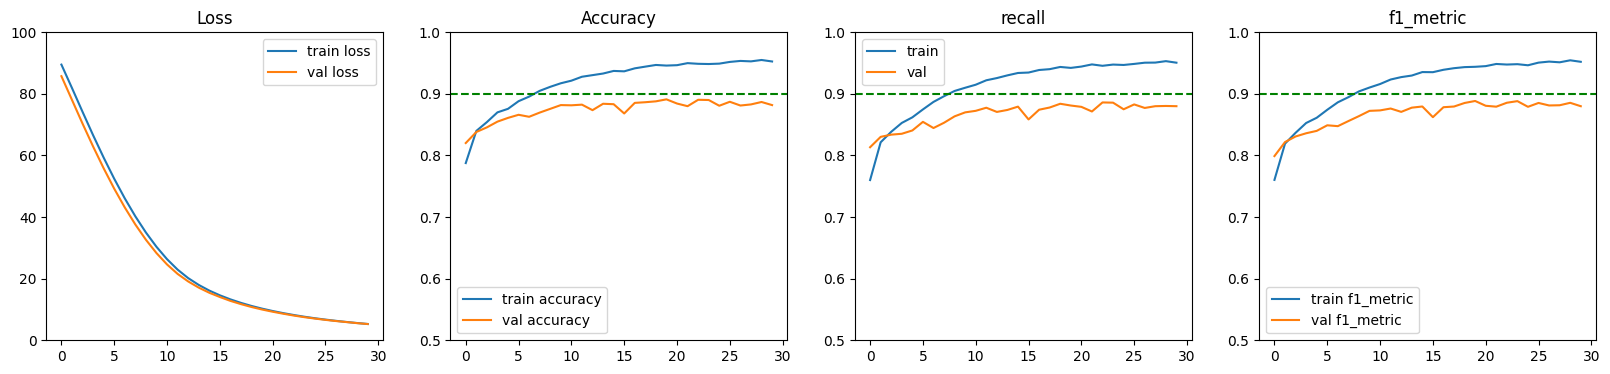

In [171]:
# removed dropout layer to see if the performance is better.

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):82.0

layers.RandomZoom(0.5)
dense_layer = layers.Dense(128, activation='relu')
layers.Dropout(0.125),
opt = optimizers.legacy.Adam(learning_rate=1e-6)

81/81 [==============================] - 23s 283ms/step - loss: 7.6611 - accuracy: 0.8876 - recall: 0.8880 - f1_metric: 0.8846


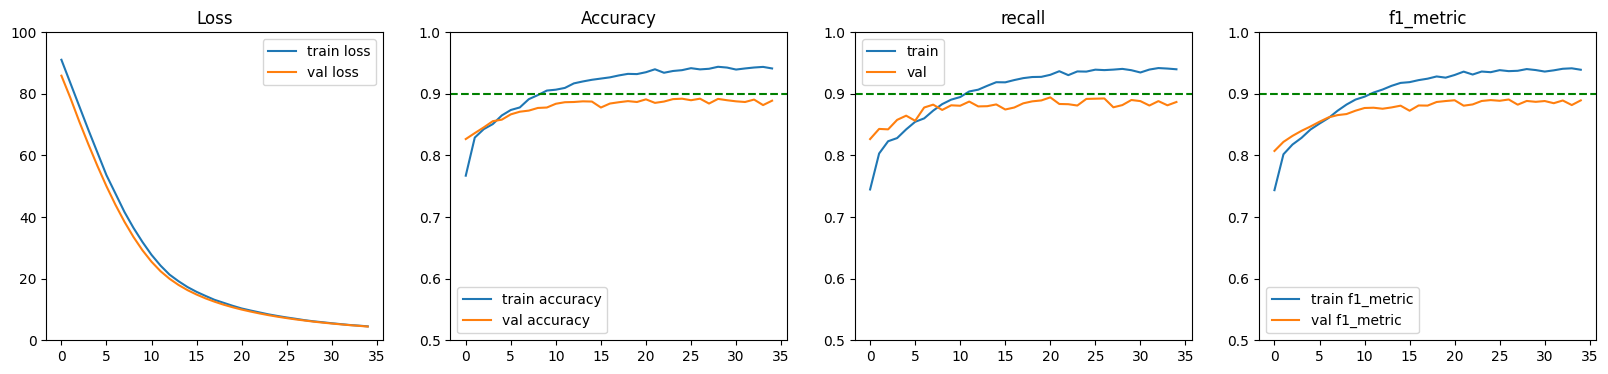

In [167]:
# both recall and accuracy were clsoe to 90%

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):47.0

layers.RandomZoom(0.5)
dense_layer = layers.Dense(128, activation='relu')
patience = 10,
num_epochs = 10

81/81 [==============================] - 24s 292ms/step - loss: 0.7377 - accuracy: 0.8698 - recall: 0.8617 - f1_metric: 0.8681


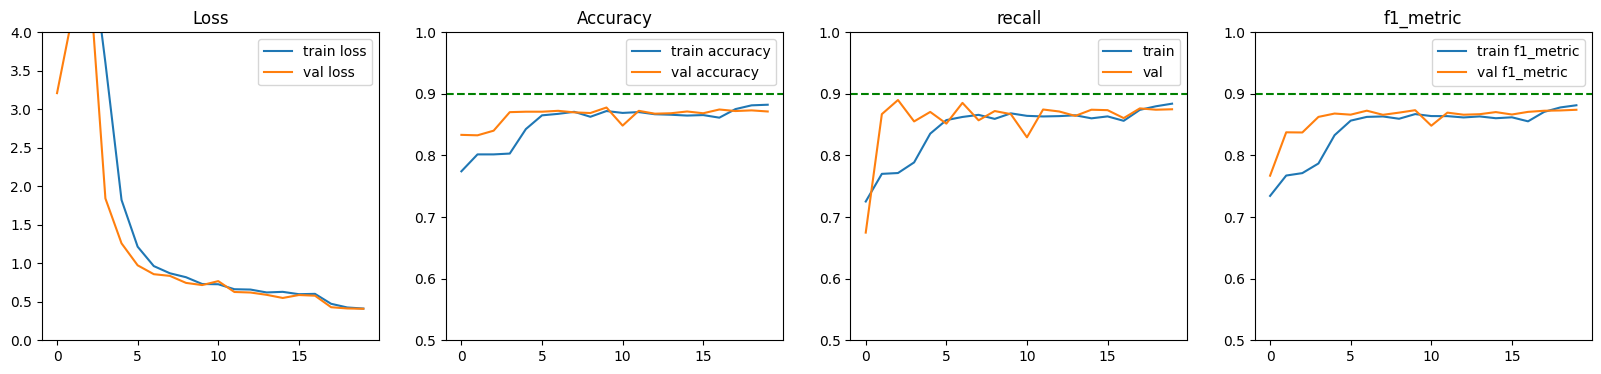

In [158]:
#the model seems stable and no overfitting

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):25.0

layers.RandomZoom(0.5)
dense_layer = layers.Dense(128, activation='relu')
patience = 10,
num_epochs = 10

81/81 [==============================] - 23s 280ms/step - loss: 0.4239 - accuracy: 0.8694 - recall: 0.8679 - f1_metric: 0.8680


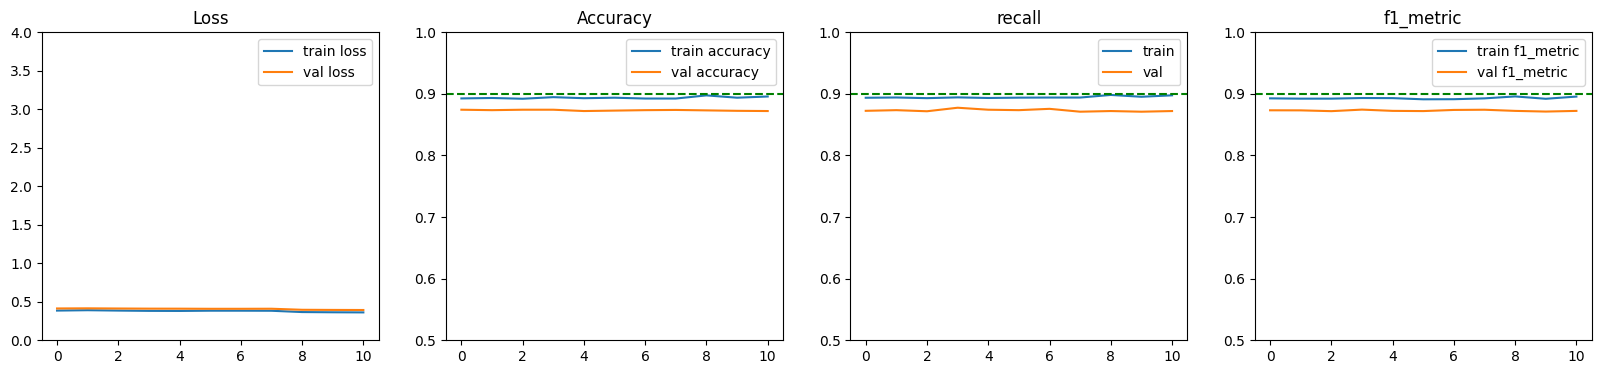

In [149]:
#lets try another 30 epochs and see if further reduced learning rate can help

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):70.0

layers.RandomZoom(0.5)
dense_layer = layers.Dense(128, activation='relu')
patience = 10,
num_epochs = 10

81/81 [==============================] - 25s 306ms/step - loss: 0.4277 - accuracy: 0.8683 - recall: 0.8671 - f1_metric: 0.8676


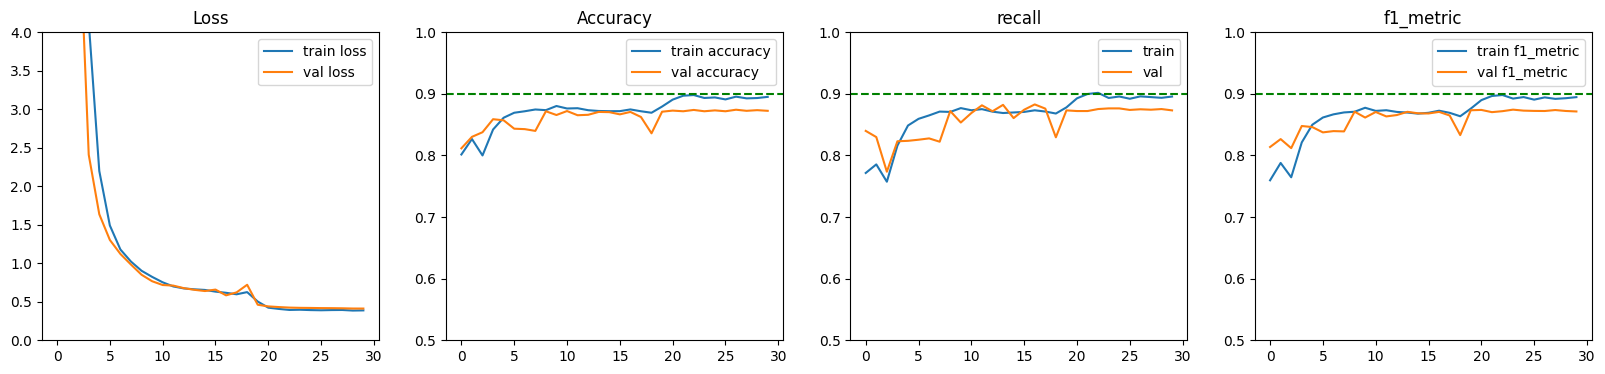

In [146]:
# tried a revised model, now the train and val are close. but the learning seems a lot more slower

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):64.0

layers.RandomZoom(0.5)
dense_layer = layers.Dense(128, activation='relu')
dense_layer2 = layers.Dense(32, activation='relu')
patience = 10,
num_epochs = 50

81/81 [==============================] - 21s 257ms/step - loss: 0.5679 - accuracy: 0.8872 - recall: 0.8822 - f1_metric: 0.8804


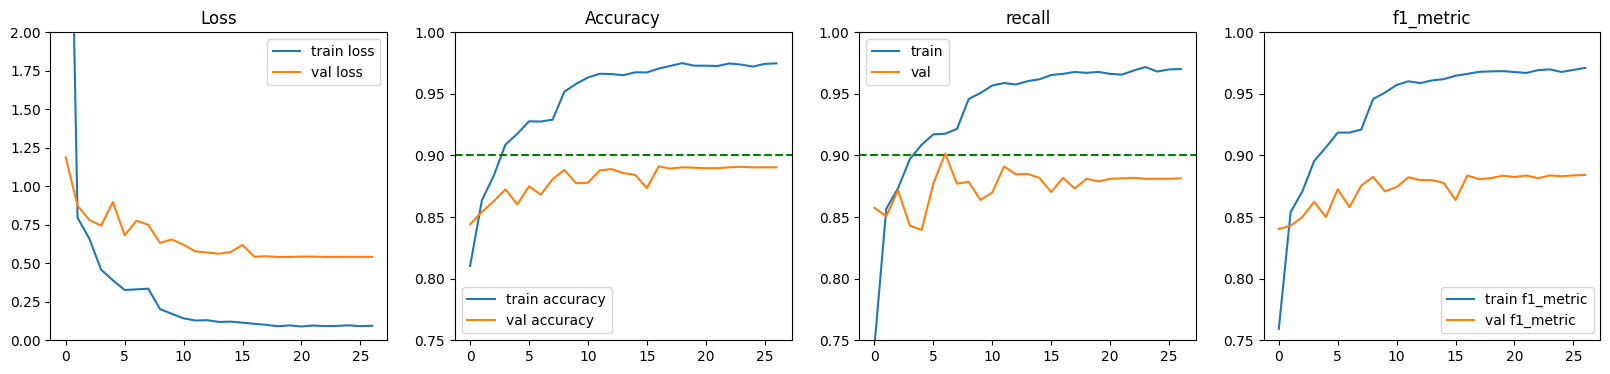

In [112]:
# the result seems reached the limit recall=88%

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):22.0

layers.RandomZoom(0.5)
dense_layer = layers.Dense(128, activation='relu')
dense_layer2 = layers.Dense(32, activation='relu')
num_epochs = 10

81/81 [==============================] - 23s 285ms/step - loss: 0.5175 - accuracy: 0.8795 - recall: 0.8521 - f1_metric: 0.8661


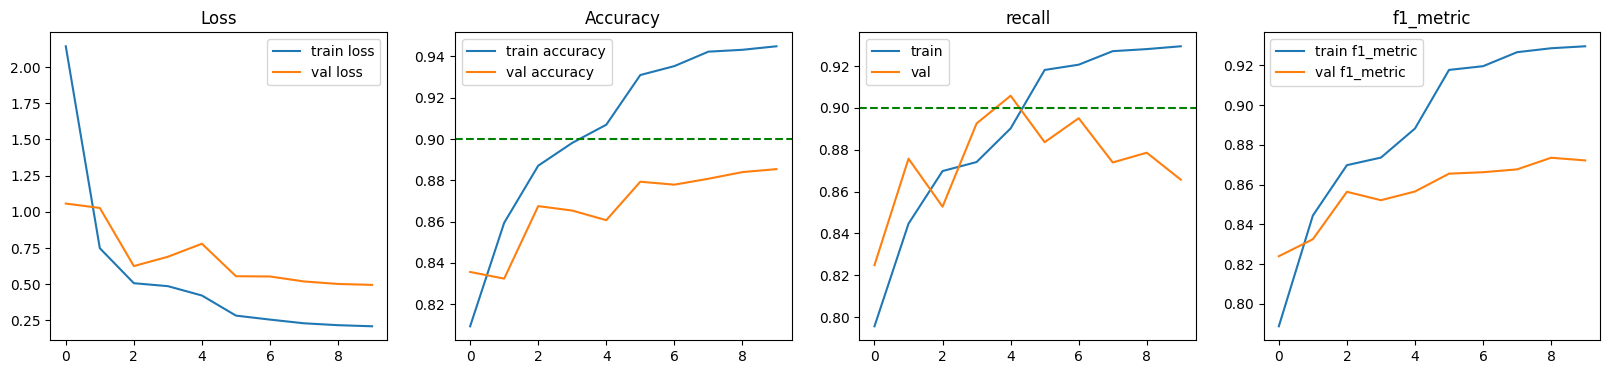

In [102]:
#seems 128+32 in the last two layers is a pretty good try

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):23.0

layers.RandomZoom(0.5)
dense_layer = layers.Dense(192, activation='relu')
dense_layer2 = layers.Dense(64, activation='relu')
num_epochs = 10

81/81 [==============================] - 25s 309ms/step - loss: 0.7397 - accuracy: 0.8714 - recall: 0.8324 - f1_metric: 0.8539


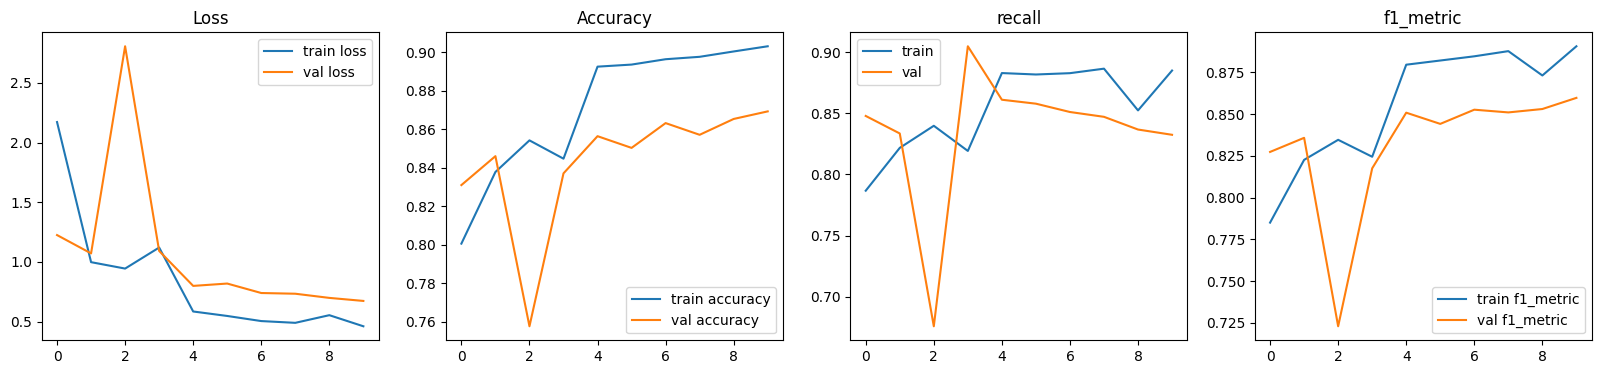

In [93]:
# 192+64 seems made the model confused.

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):32.0

layers.RandomZoom(0.5)
dense_layer = layers.Dense(192, activation='relu')
num_epochs = 30

81/81 [==============================] - 22s 272ms/step - loss: 0.6050 - accuracy: 0.8857 - recall: 0.8884 - f1_metric: 0.8810


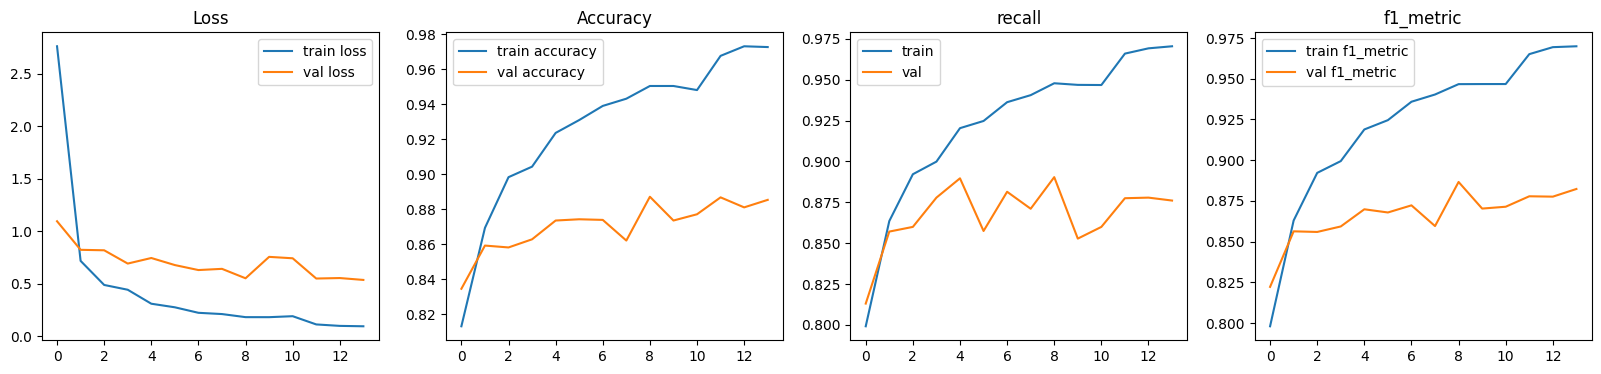

In [86]:
#192 unit at the last layer

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):44.0

layers.RandomZoom(0.5)
epochs = 20
dense_layer = layers.Dense(128, activation='relu')

81/81 [==============================] - 25s 308ms/step - loss: 0.3844 - accuracy: 0.8799 - recall: 0.8687 - f1_metric: 0.8734


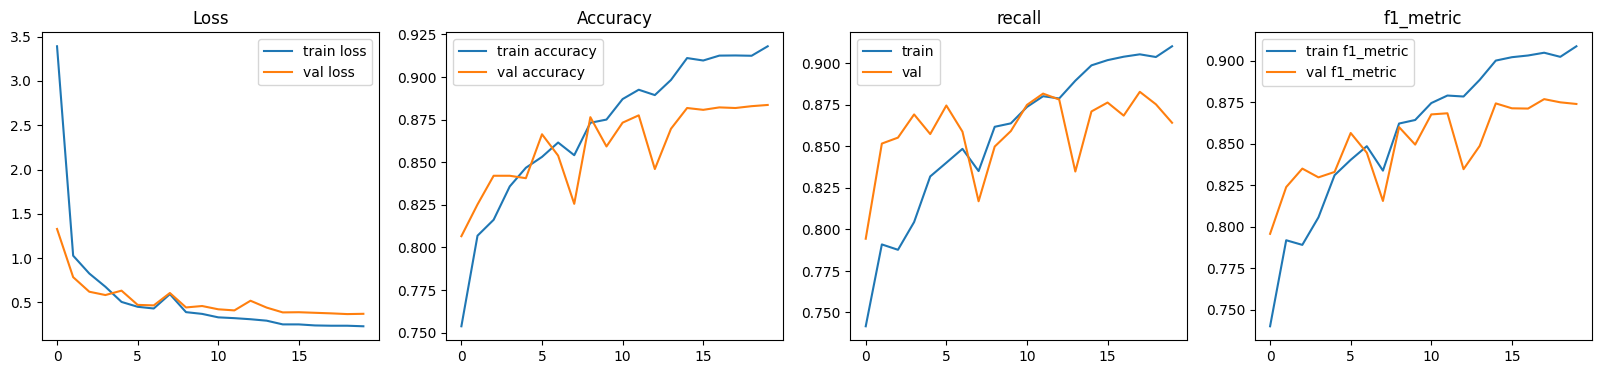

In [82]:
# zoom=1.0 does not seem better

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):23.0

layers.RandomZoom(0.5)
epochs = 20
dense_layer = layers.Dense(128, activation='relu')

81/81 [==============================] - 23s 280ms/step - loss: 0.4209 - accuracy: 0.8864 - recall: 0.8857 - f1_metric: 0.8798


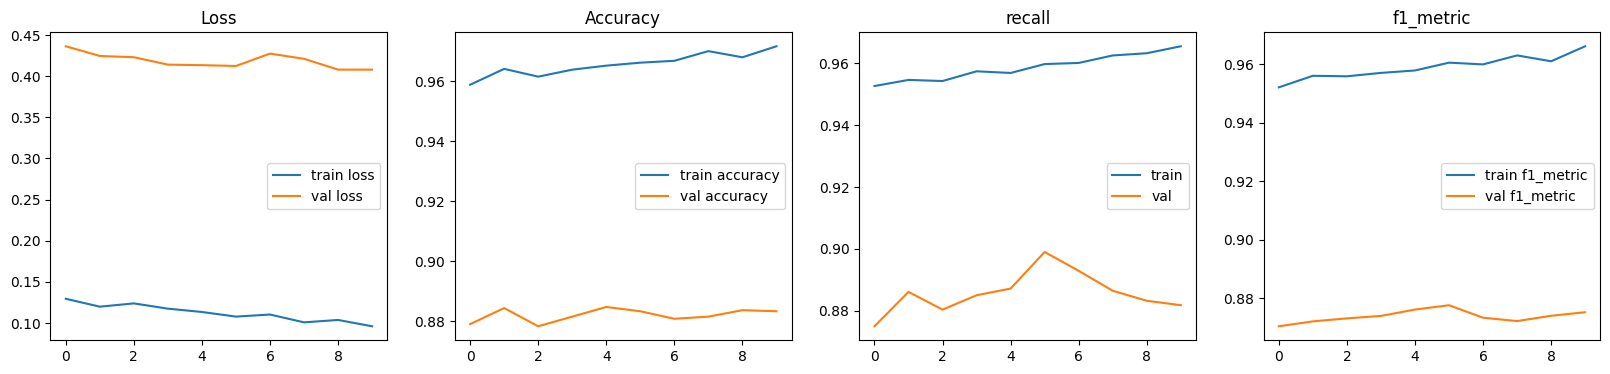

In [78]:
# second 10 epochs

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):22.0

layers.RandomZoom(0.5)
epochs = 20
dense_layer = layers.Dense(128, activation='relu')

81/81 [==============================] - 23s 276ms/step - loss: 0.4155 - accuracy: 0.8849 - recall: 0.8891 - f1_metric: 0.8742


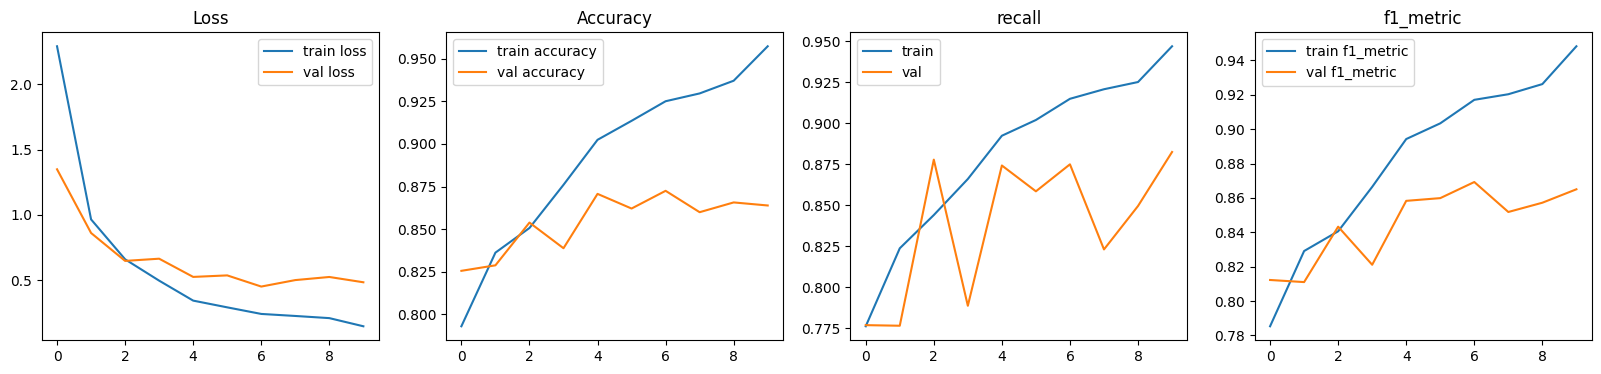

In [76]:
# first 10 epochs

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):22.0

layers.RandomZoom(0.25)
epochs = 20
dense_layer = layers.Dense(128, activation='relu')

81/81 [==============================] - 23s 279ms/step - loss: 0.3899 - accuracy: 0.8942 - recall: 0.8922 - f1_metric: 0.8916


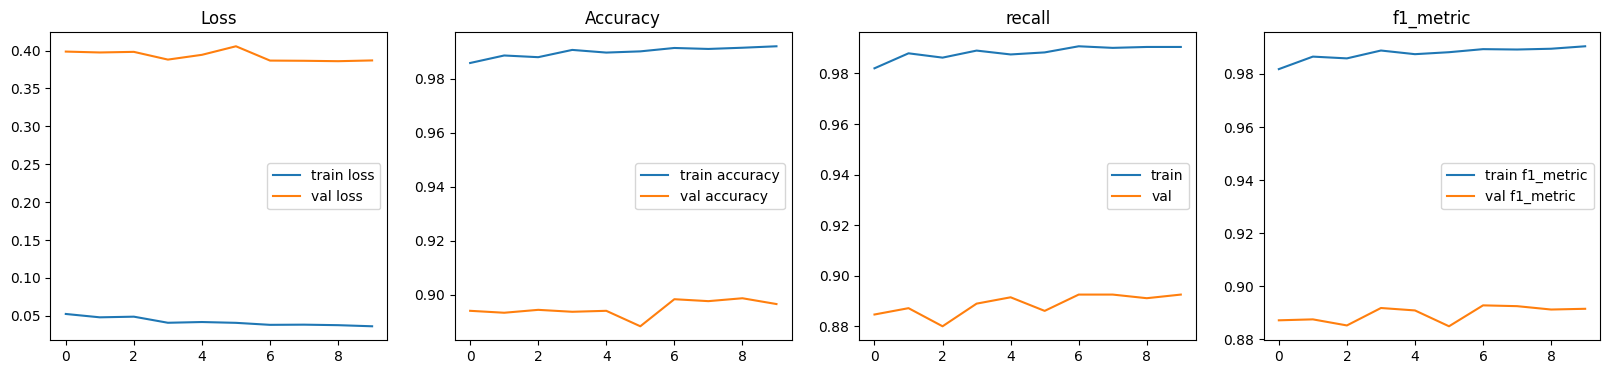

In [71]:
#third 10 epochs

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):22.0

layers.RandomZoom(0.25)
dense_layer = layers.Dense(128, activation='relu')

81/81 [==============================] - 22s 268ms/step - loss: 0.4277 - accuracy: 0.8861 - recall: 0.8830 - f1_metric: 0.8813


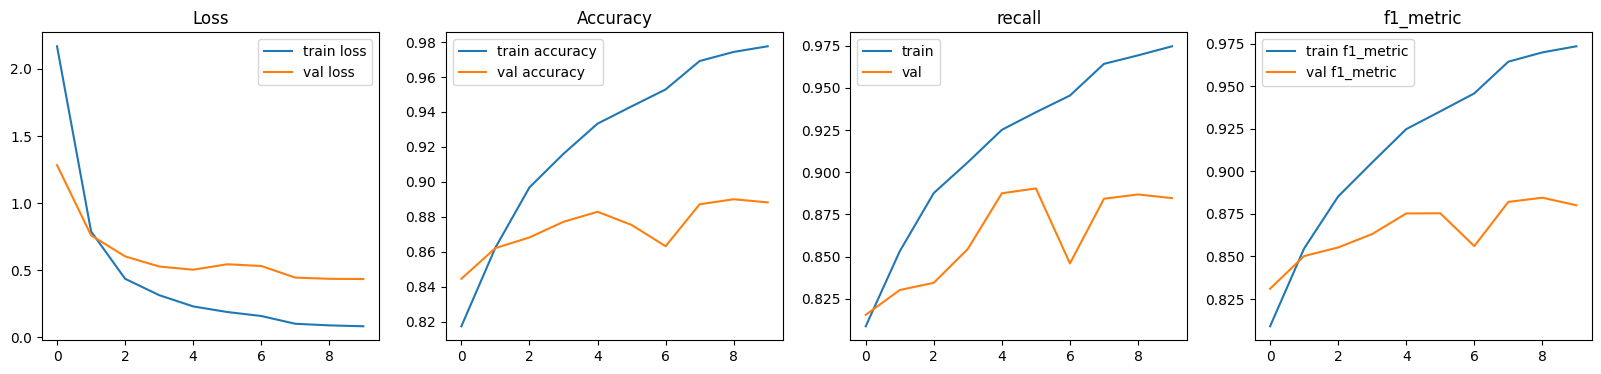

In [66]:
#first 10 epochs

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):22.0

layers.RandomZoom(0.0)
dense_layer = layers.Dense(128, activation='relu')

81/81 [==============================] - 21s 260ms/step - loss: 0.8875 - accuracy: 0.8822 - recall: 0.8783 - f1_metric: 0.8786


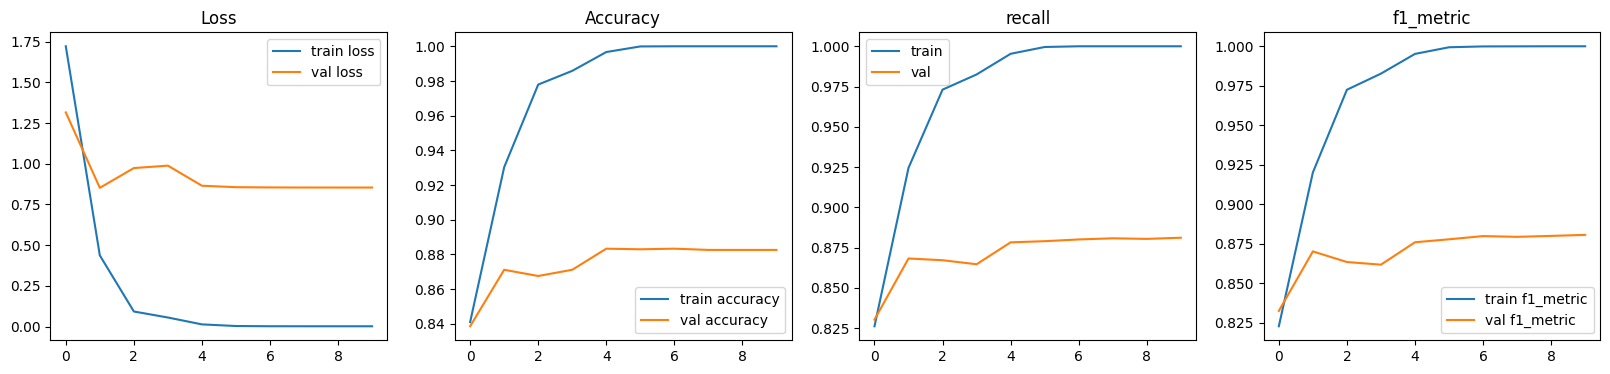

In [62]:
#baseline

# Results (7 --> binary  with unbalanced data)

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):71.0

layers.RandomZoom(0.5),
loss_weights=[0.5, 1.0, 1.0])
patience = 5, 
batch_size = 32
base_model = set_nontrainable_layers(model, 45)
dense_layer = layers.Dense(128, activation='relu')

81/81 [==============================] - 23s 279ms/step - loss: 0.2231 - accuracy: 0.8656 - recall: 0.8629 - f1_metric: 0.8614


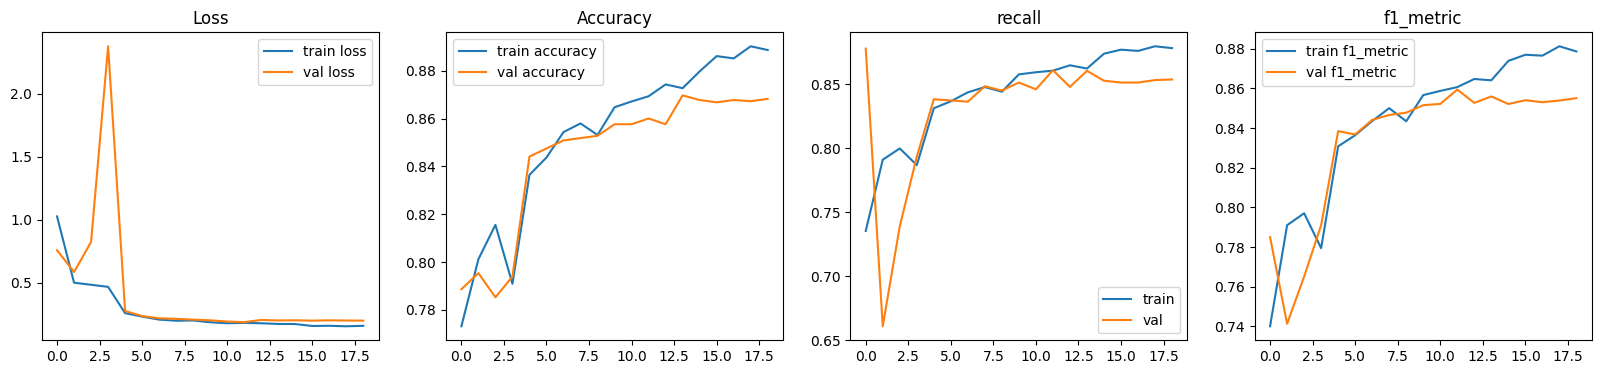

In [90]:
# Try to open more layers

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):55.0

layers.RandomZoom(0.5),
loss_weights=[0.5, 1.0, 1.0])
patience = 5, 
batch_size = 32
base_model = set_nontrainable_layers(model, 45)
dense_layer = layers.Dense(128, activation='relu')

81/81 [==============================] - 22s 274ms/step - loss: 0.2735 - accuracy: 0.8459 - recall: 0.8289 - f1_metric: 0.8332


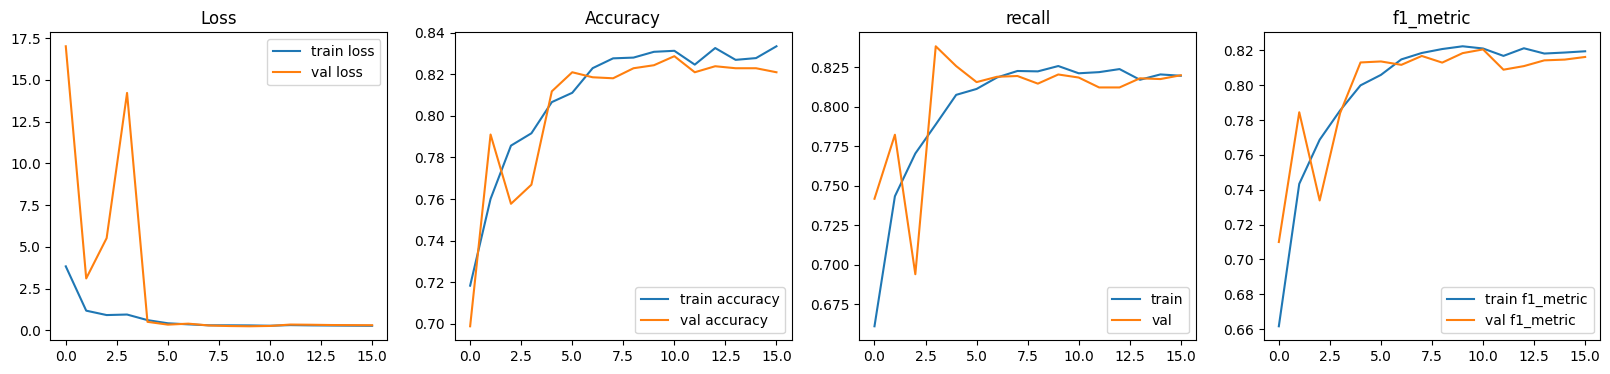

In [84]:
#     base_model = set_nontrainable_layers(model,48), open the last 3 layers

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):67.0

layers.RandomZoom(0.5),
loss_weights=[0.5, 1.0, 1.0])
patience = 5, 
batch_size = 32
base_model = set_nontrainable_layers(model, 45)
dense_layer = layers.Dense(128, activation='relu')

81/81 [==============================] - 24s 292ms/step - loss: 0.2299 - accuracy: 0.8393 - recall: 0.8266 - f1_metric: 0.8305


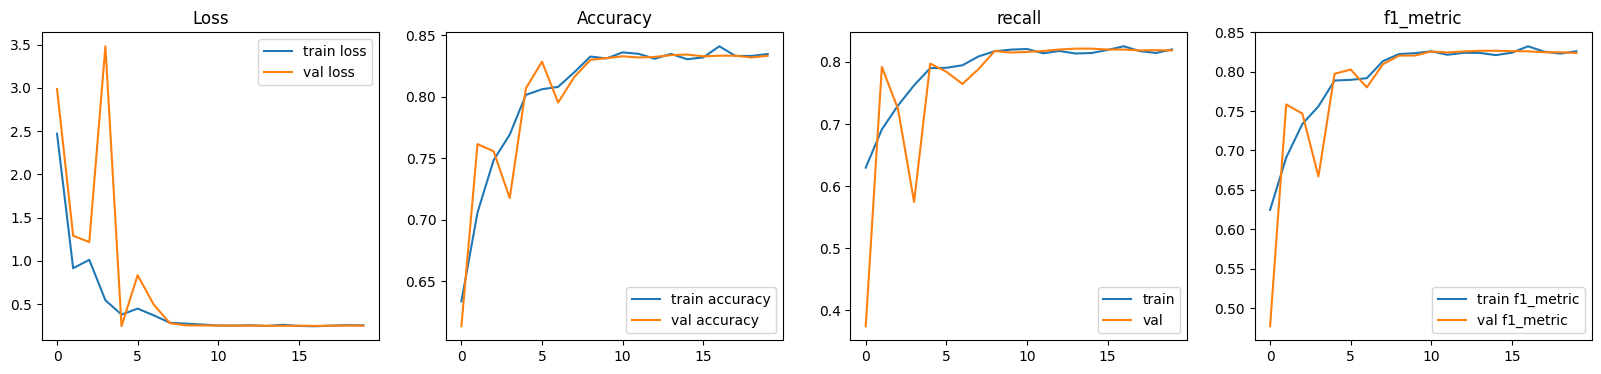

In [73]:
# set the first 45 layers not trainable, open the last 5 layers

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):47.0

layers.RandomZoom(0.5),
loss_weights=[0.5, 1.0, 1.0])
patience = 5, 
batch_size = 32
base_model = set_nontrainable_layers(model, 40)
dense_layer = layers.Dense(128, activation='relu')

81/81 [==============================] - 21s 261ms/step - loss: 0.1669 - accuracy: 0.8903 - recall: 0.8822 - f1_metric: 0.8842


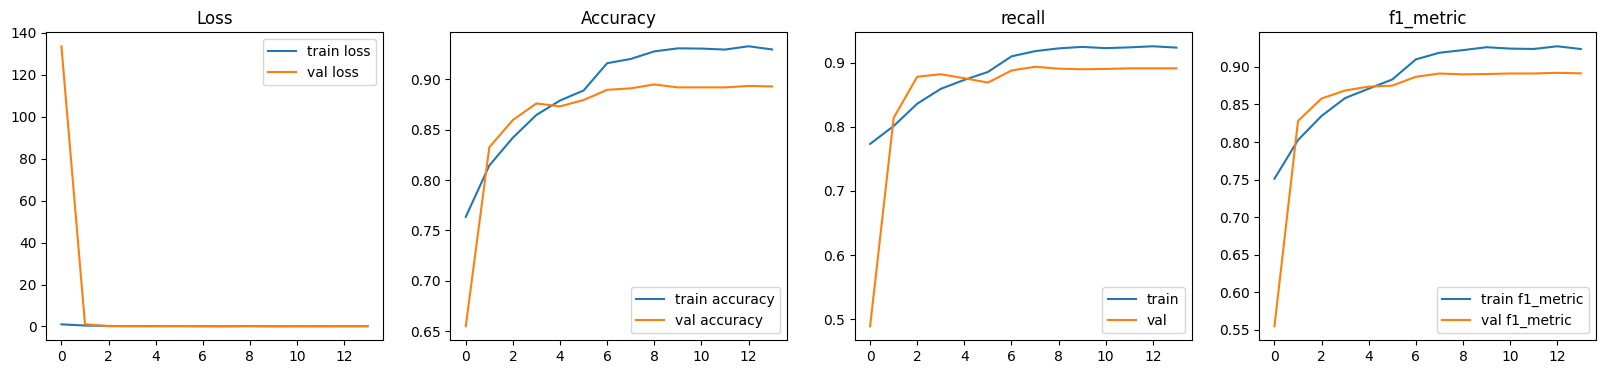

In [69]:
# set the first 40 layers not trainable, open the last 10 layers

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):17.0

layers.RandomZoom(0.5),
loss_weights=[0.5, 1.0, 1.0])
patience = 5, 
batch_size = 64

81/81 [==============================] - 23s 287ms/step - loss: 0.2507 - accuracy: 0.8857 - recall: 0.8795 - f1_metric: 0.8782


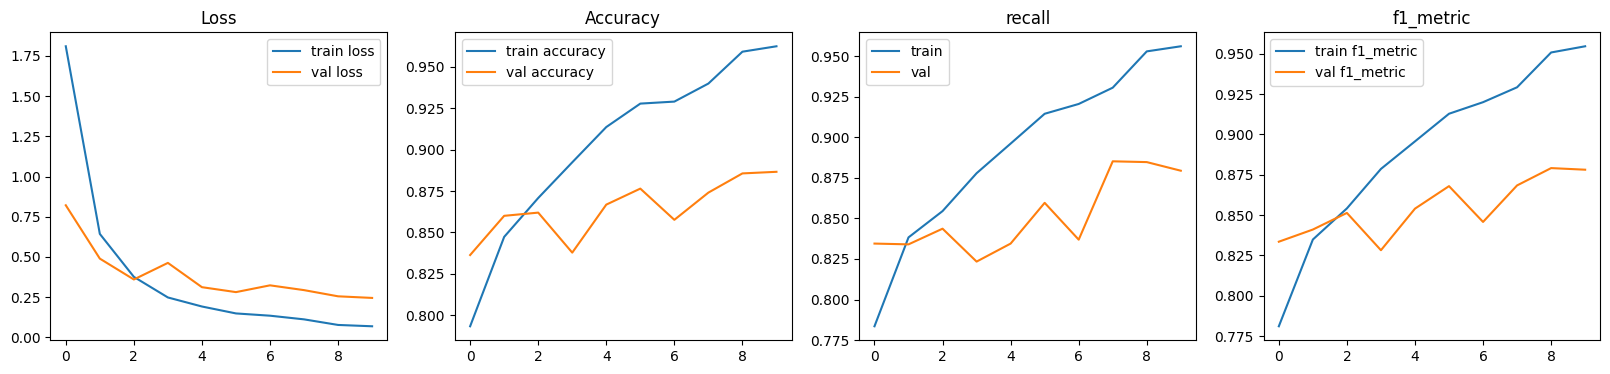

In [104]:
#it seems the batch_size = 64 does not really affect the performance

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):44.0

layers.RandomZoom(0.25),
loss_weights=[0.25, 1.0, 1.0])
patience = 5, 

81/81 [==============================] - 22s 267ms/step - loss: 0.1055 - accuracy: 0.8907 - recall: 0.8965 - f1_metric: 0.8838


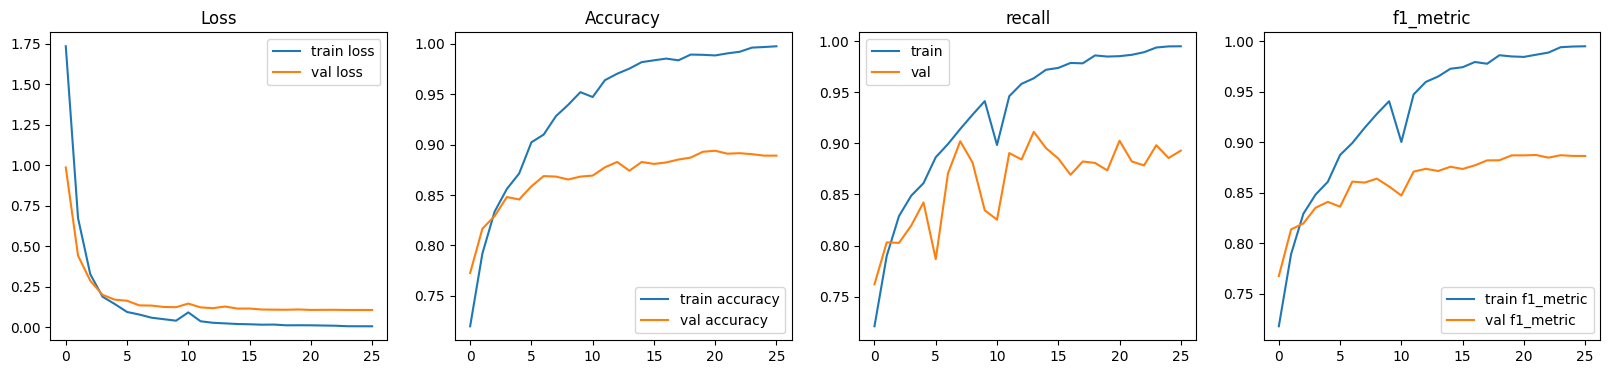

In [68]:
# try a smaller zoom out and see how the learning process is affected
# should be faster. the recall is quite stable above 89%.

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):25.0

layers.RandomZoom(0.25),
loss_weights=[1.0, 1.0, 1.0],
loss_weights=[0.25, 1.0, 1.0])
patience = 5, 

81/81 [==============================] - 22s 272ms/step - loss: 0.1574 - accuracy: 0.8849 - recall: 0.8783 - f1_metric: 0.8791


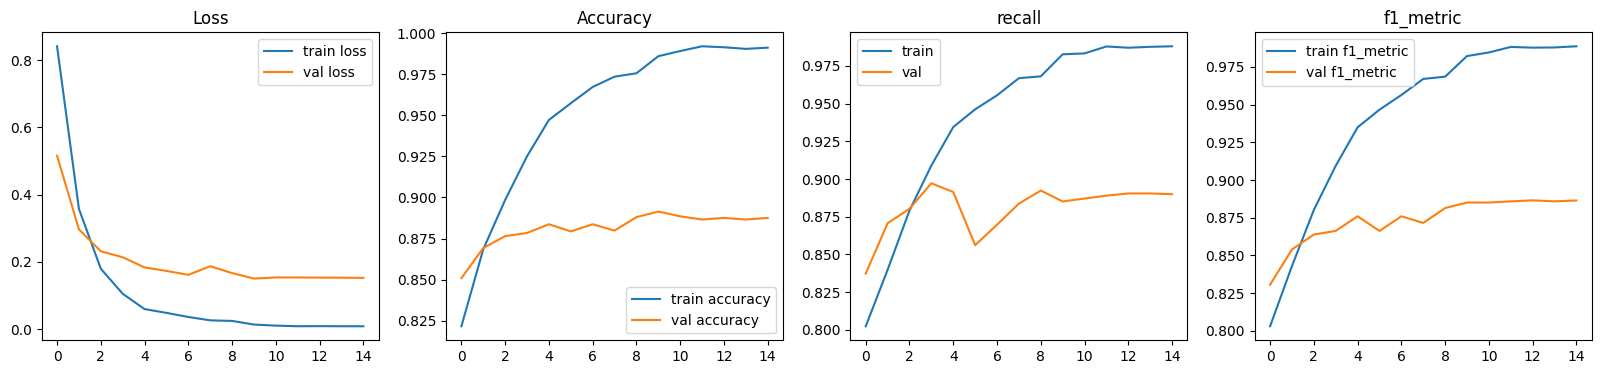

In [61]:
# try a smaller zoom out and see how the learning process is affected
# should be faster. the recall is quite stable above 89%.
# should try a larger epochs

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):25.0

layers.RandomZoom(1.0),
loss_weights=[1.0, 1.0, 1.0],
loss_weights=[0.25, 1.0, 1.0])
patience = 5, 

81/81 [==============================] - 23s 275ms/step - loss: 0.1120 - accuracy: 0.8783 - recall: 0.8656 - f1_metric: 0.8687


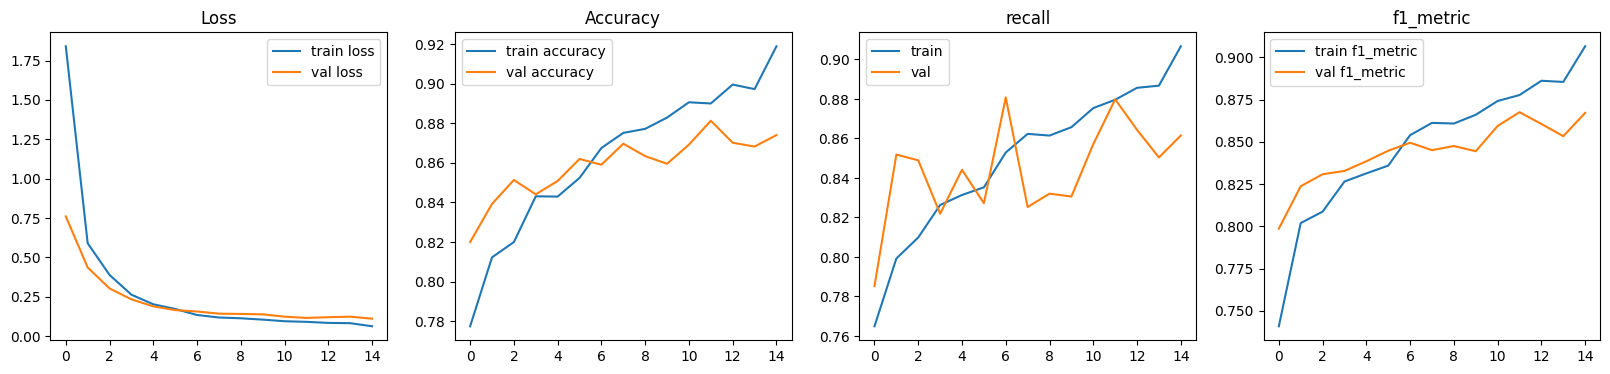

In [57]:
# the model learning speed is a lot slower (accruacy and recall improve to 90% after 15 epochs) 
# the best val_recall was 88% at epoch=7
# ** may try epochs=30 later

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):51.0

layers.RandomZoom(0.5),
loss_weights=[1.0, 1.0, 1.0],
loss_weights=[0.25, 1.0, 1.0])
patience = 10, 

81/81 [==============================] - 22s 269ms/step - loss: 0.1072 - accuracy: 0.8826 - recall: 0.8652 - f1_metric: 0.8764


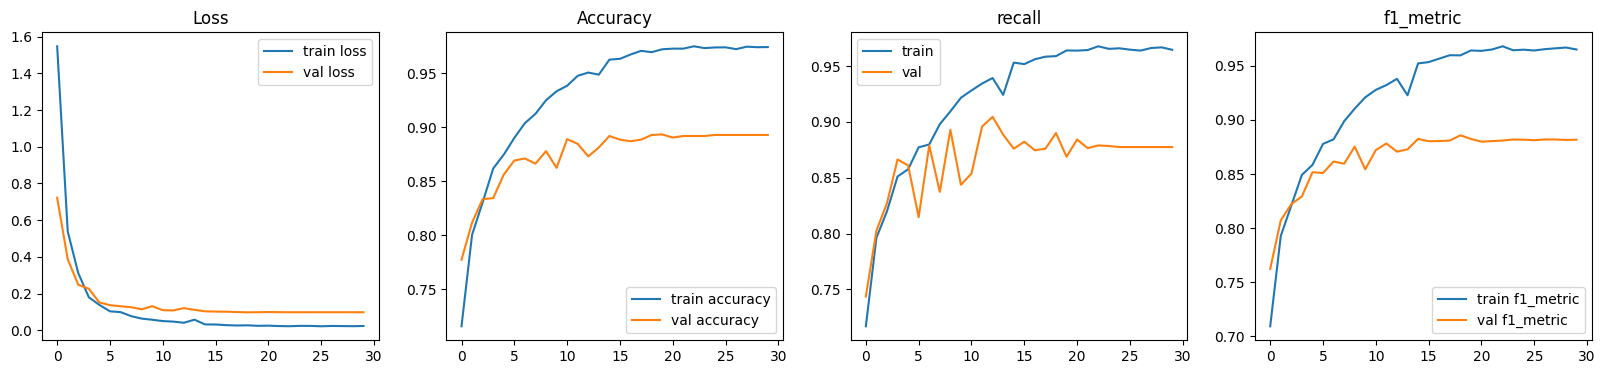

In [53]:
# increase patience to 10

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):32.78527231805007

layers.RandomZoom(0.5),
loss_weights=[1.0, 1.0, 1.0],
loss_weights=[0.25, 1.0, 1.0])

81/81 [==============================] - 26s 318ms/step - loss: 0.1433 - accuracy: 0.8872 - recall: 0.8822 - f1_metric: 0.8825


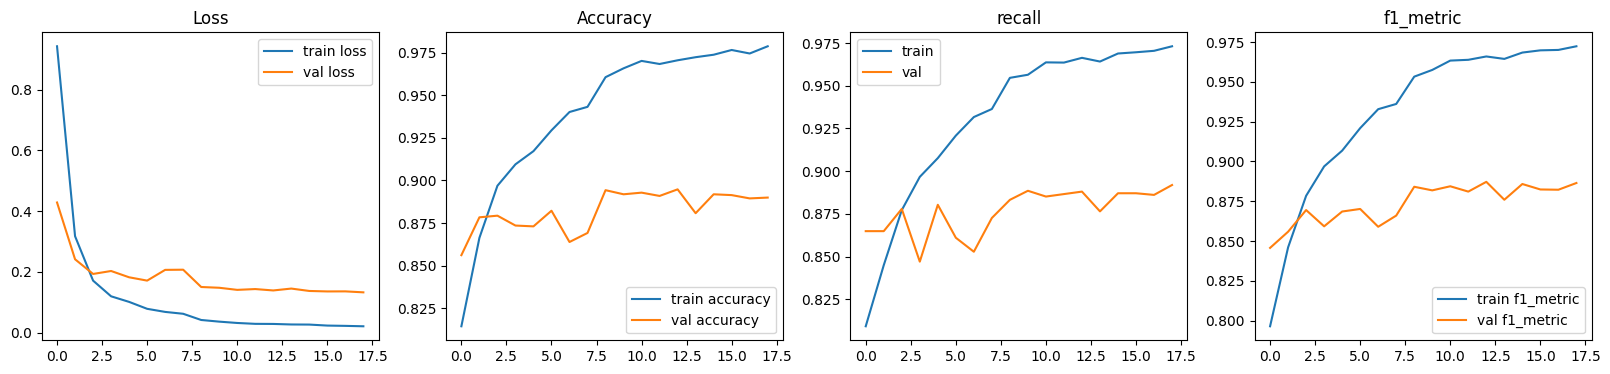

In [48]:
# try further increase the recall weight to be four times the accuracy. 
# result is no better, try to increase patience

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):24.761471561799407

layers.RandomZoom(0.5),
loss_weights=[1.0, 1.0, 1.0],
loss_weights=[0.5, 1.0, 1.0])

81/81 [==============================] - 22s 267ms/step - loss: 0.2400 - accuracy: 0.8822 - recall: 0.9158 - f1_metric: 0.8735


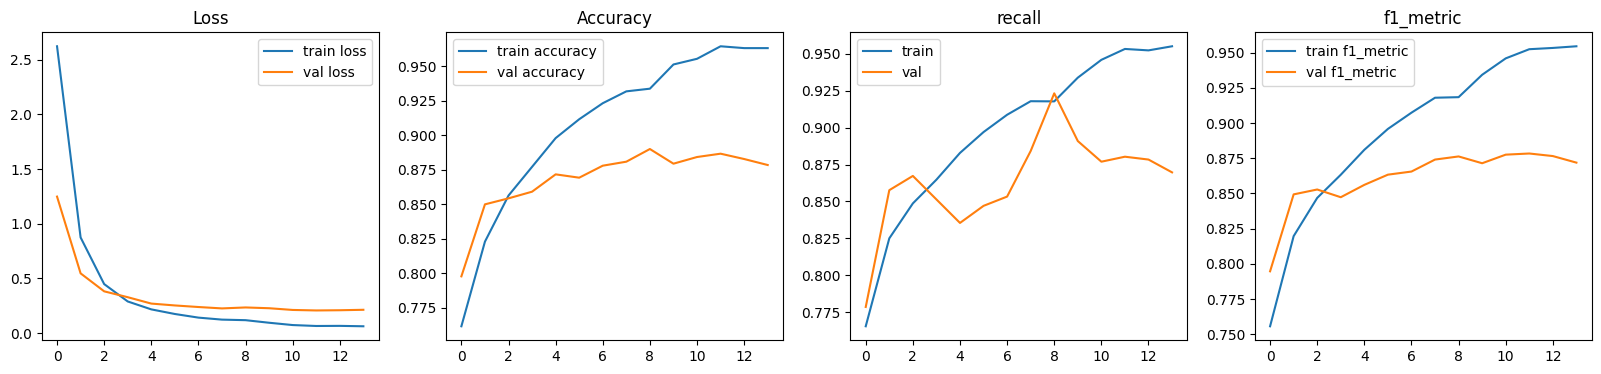

In [44]:
# epoch=9: managed to achieve recall>90% and accuracy 89%
# need to try further increase the recall weight

scenario: ResNet50_../cat_7_binary_../cat_7_binary, training time(min):31.61399424931636

layers.RandomZoom(0.5),
loss_weights=[1.0, 1.0, 1.0]

81/81 [==============================] - 22s 269ms/step - loss: 0.7278 - accuracy: 0.8888 - recall: 0.8903 - f1_metric: 0.8876


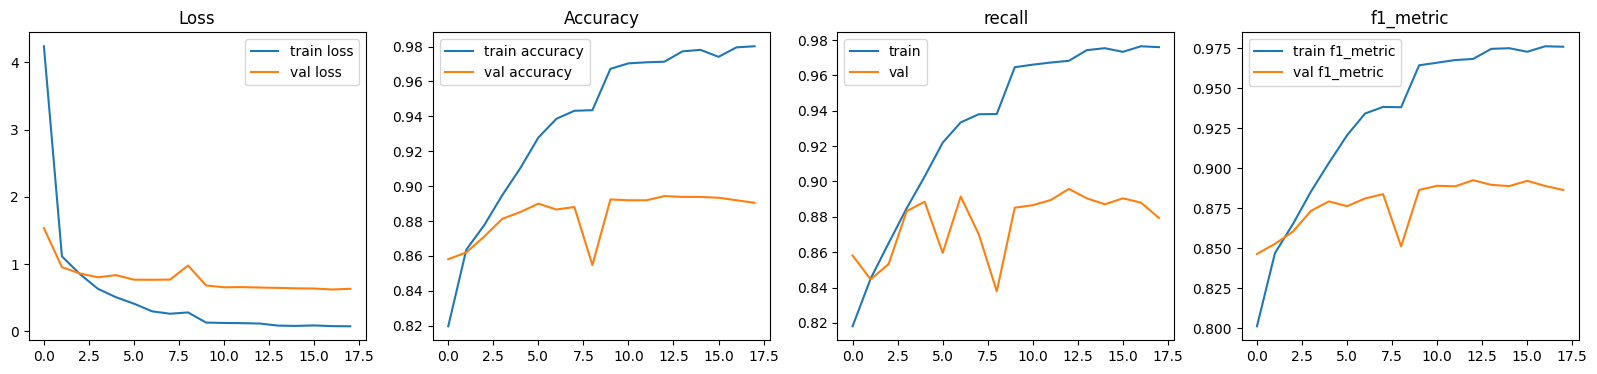

In [40]:
# test result comment: best result so far.
# want to improve val_recall to be above 90%
# try adjust weight

scenario: ResNet50_../cat_7_binary, training time(min):10.0

layers.RandomZoom(0.5),
loss_weights=[1.0, 1.0, 1.0]

81/81 [==============================] - 22s 269ms/step - loss: 2.0040 - accuracy: 0.8521 - recall: 0.8752 - f1_metric: 0.8413


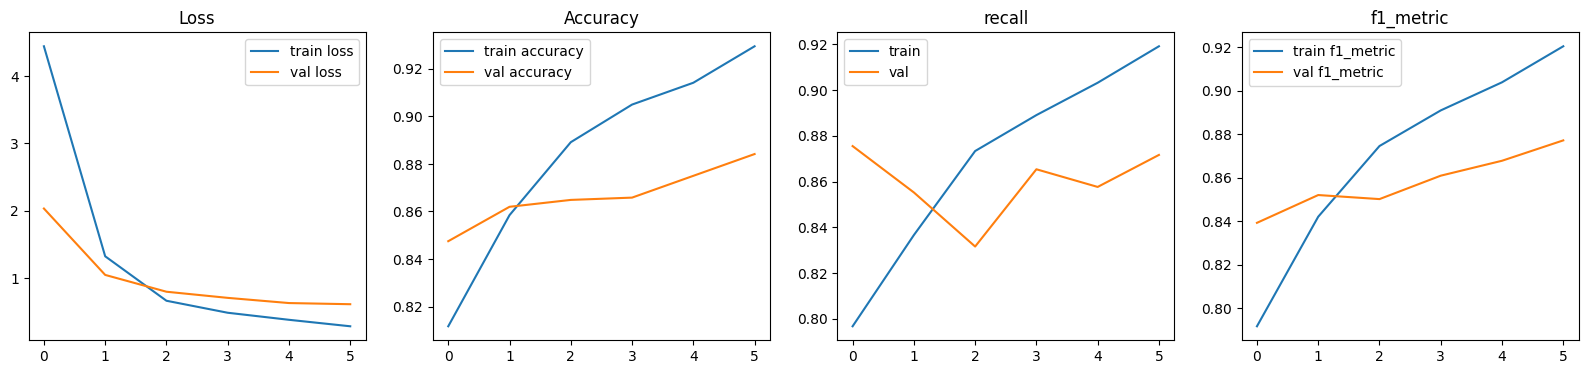

In [21]:
# test result comment: early stopped at epoch=6 due to the es was set on val_recall
# the result was similar to the test case below
# will need to try to set es on val_loss with the same model

scenario: ResNet50_../cat_7_binary, training time(min):13.0

layers.RandomZoom(0.5),
loss_weights=[1.0, 1.0, 1.0]

81/81 [==============================] - 23s 276ms/step - loss: 0.6354 - accuracy: 0.8764 - recall: 0.8691 - f1_metric: 0.8720


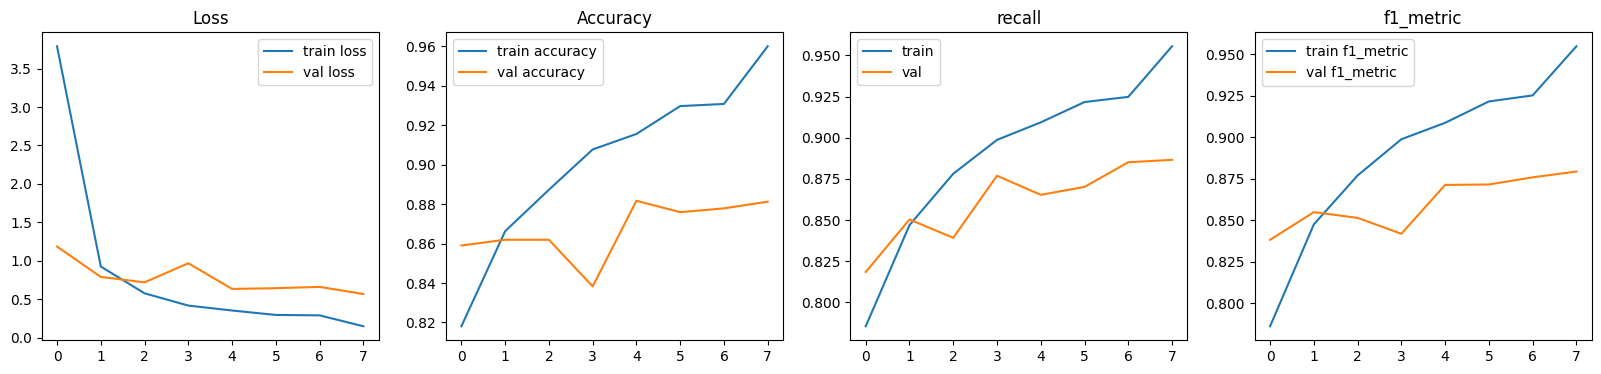

In [17]:
# test result comment: tried to add image zoom argumentation, 
# but the fitting was early stopped at epoch 6 on es = val_recall
# need to increase patience to 5

scenario: ResNet50_../cat_7_binary, training time(min):13.0

layers.RandomZoom(0.0),
loss_weights=[1.0, 1.0, 1.0]

81/81 [==============================] - 22s 266ms/step - loss: 0.6521 - accuracy: 0.8806 - recall: 0.8772 - f1_metric: 0.8712


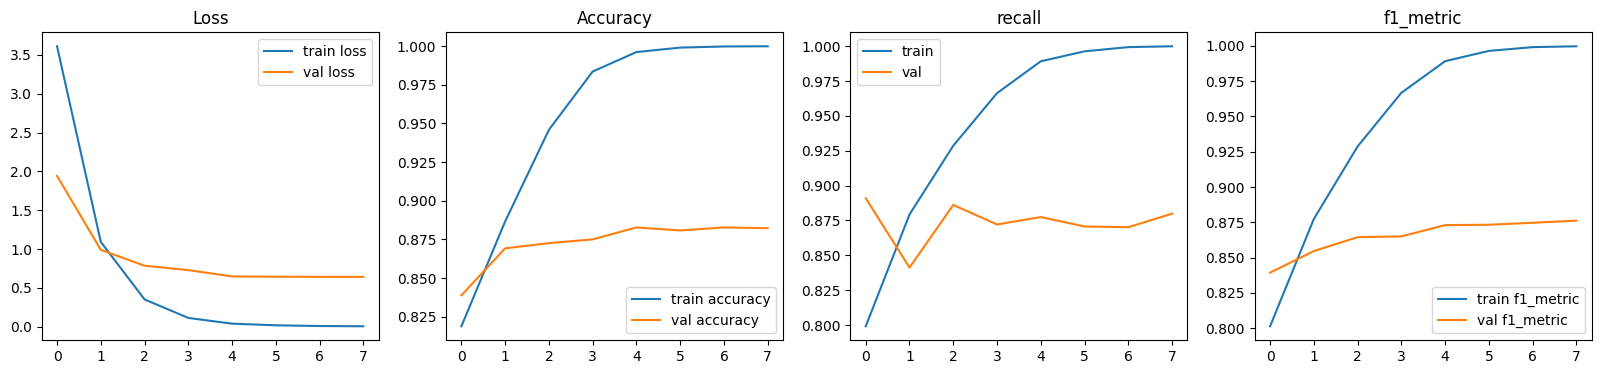

In [13]:
# test result comment: default setting first try. the result was not bad. 
# how can we improve recall to be above 0.9 ???